# gluonts12-end_dates (quarterly, deepar)

This notebook is used to check the performance of `deepar` on the quarterly subsets of the m4 data with the same end dates. 

In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import gluonts
print(gluonts.__version__)

import mxnet
print(mxnet.__version__)

# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar

0.4.2
1.4.1


INFO:root:Using CPU


In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

## Check datasets

In [5]:
dataname = "m4_weekly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_weekly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json


**To do:** Transfer the quarterly datasets to the right place: 

- `mv [data] ../../.mxnet/gluon-ts/datasets

In [7]:
dataname1 = "m4_quarterly_end2003q3"
dataset1 = utils.get_dataset(dataname1, regenerate=False)
len(dataset1.train) # 728

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.


728

In [8]:
dataname2 = "m4_quarterly_end2013q1"
dataset2 = utils.get_dataset(dataname2, regenerate=False)
len(dataset2.train) # 1119

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2013q1.


1119

In [9]:
dataname3 = "m4_quarterly_end2015q1"
dataset3 = utils.get_dataset(dataname3, regenerate=False)
len(dataset3.train) # 4126

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2015q1.


4126

In [10]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset 359
length test dataset 359


In [11]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json'), line=1), row=1)}

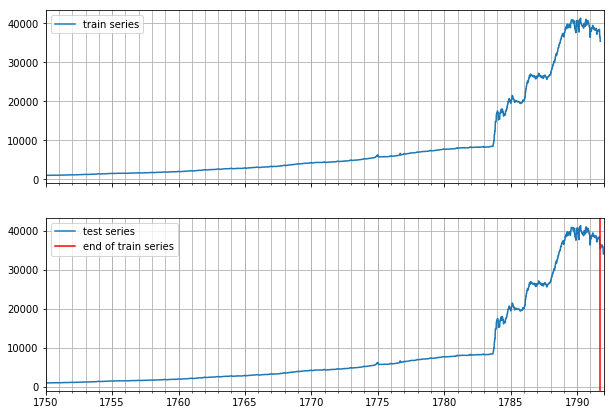

In [12]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [13]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [14]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

## Study 1: `m4_quarterly_end2003q3`

In [16]:
dataname1

'm4_quarterly_end2003q3'

In [17]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname1, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 66923


Seed: 42


100%|██████████| 50/50 [00:01<00:00, 48.11it/s, avg_epoch_loss=7.79]
INFO:root:Epoch[0] Elapsed time 1.042 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.791034
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.52it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[1] Elapsed time 0.856 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.943775
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.59it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[2] Elapsed time 0.855 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.784812
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.92it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[3] Elapsed time 0.796 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.686188
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.36it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.791 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.03it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[38] Elapsed time 0.834 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.811952
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.78it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[39] Elapsed time 0.798 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.763460
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.42it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 0.805 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.604384
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.10it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[41] Elapsed time 0.862 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.633385
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.20it/s, avg_epoch_loss=5.84]
INFO:root:Epo

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.664491
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 60.21it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[75] Elapsed time 0.832 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.648321
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 58.18it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[76] Elapsed time 0.861 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.615535
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 59.48it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[77] Elapsed time 0.842 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.616536
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 59.38it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[78] Elapsed time 0.843 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.654530
INFO:root:Epoch[79] Learning rate is 0.000125
100%|█

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.01802  0.040309  17.254294            0.042094            0.026847    42   

   epochs  num_batches  
0     100           50  
Seed: 43


100%|██████████| 50/50 [00:00<00:00, 55.14it/s, avg_epoch_loss=8.16]
INFO:root:Epoch[0] Elapsed time 0.908 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.155259
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.28it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[1] Elapsed time 0.831 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.008824
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.38it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[2] Elapsed time 0.790 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.920336
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 54.25it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[3] Elapsed time 0.923 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.739189
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 51.07it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[4] Elapsed time 0.981 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.38it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[38] Elapsed time 0.816 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.588606
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 54.40it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[39] Elapsed time 0.921 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.672429
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.25it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[40] Elapsed time 0.831 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.651976
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.98it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[41] Elapsed time 0.879 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.664900
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.06it/s, avg_epoch_loss=5.53]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 54.45it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[75] Elapsed time 0.920 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.457696
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 60.93it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[76] Elapsed time 0.822 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.463578
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 56.47it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[77] Elapsed time 0.887 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.413077
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 55.60it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[78] Elapsed time 0.901 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.411476
INFO:root:Loading parameters from best epoch (68)
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 58.92it/s, avg_epoch_loss=5.41]


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.047827  0.039501  18.146735            0.042738            0.030038   

   seed  epochs  num_batches  
0    43     100           50  
Seed: 44


100%|██████████| 50/50 [00:00<00:00, 56.58it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[0] Elapsed time 0.886 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.542753
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.71it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[1] Elapsed time 0.853 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.987718
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.05it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 0.879 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.801918
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.41it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[3] Elapsed time 0.843 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.774586
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.73it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[4] Elapsed time 0.853 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.11it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[38] Elapsed time 0.806 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.607715
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.12it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[39] Elapsed time 0.892 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.564563
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.46it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[40] Elapsed time 0.828 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.634368
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.13it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[41] Elapsed time 0.847 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.674744
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.01it/s, avg_epoch_loss=5.57]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 62.82it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[75] Elapsed time 0.798 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.488491
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 60.57it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 0.827 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.502742
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 57.76it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[77] Elapsed time 0.867 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.465070
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 58.63it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[78] Elapsed time 0.855 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.450359
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 57.54it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[79] Elapsed time 0.871 seconds
INFO:

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.07902  0.039957  19.433218            0.042989            0.031943    44   

   epochs  num_batches  
0     100           50  
Seed: 45


100%|██████████| 50/50 [00:00<00:00, 55.89it/s, avg_epoch_loss=8.5]
INFO:root:Epoch[0] Elapsed time 0.897 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.502765
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.86it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[1] Elapsed time 0.837 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.994712
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 52.25it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[2] Elapsed time 0.959 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.693486
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.05it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[3] Elapsed time 0.848 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.626953
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 54.95it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.912 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.24it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[38] Elapsed time 0.860 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.699138
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 54.99it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[39] Elapsed time 0.912 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.733770
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.70it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[40] Elapsed time 0.839 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.704874
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.70it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[41] Elapsed time 0.812 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.657997
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.76it/s, avg_epoch_loss=5.58]
INFO:root:Epoc

100%|██████████| 50/50 [00:00<00:00, 56.95it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[75] Elapsed time 0.880 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.394151
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.96it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 0.879 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.503692
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 52.33it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[77] Elapsed time 0.957 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.498008
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 54.44it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[78] Elapsed time 0.920 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.433578
INFO:root:Epoch[79] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.27it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[79] Elapsed time 0.845 seconds
INFO:root:

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.169611  0.04281  21.169258            0.043262            0.030315    45   

   epochs  num_batches  
0     100           50  
Seed: 46


100%|██████████| 50/50 [00:00<00:00, 57.92it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[0] Elapsed time 0.866 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.724282
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.35it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[1] Elapsed time 0.830 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.946097
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.63it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 0.840 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.818383
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.40it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[3] Elapsed time 0.829 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.676611
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.70it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[4] Elapsed time 0.799 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.42it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[38] Elapsed time 0.830 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.633555
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.56it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[39] Elapsed time 0.801 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.713769
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.44it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[40] Elapsed time 0.802 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.620011
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.91it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[41] Elapsed time 0.880 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.637312
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.51it/s, avg_epoch_loss=5.67]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 53.58it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[75] Elapsed time 0.936 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.478724
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.30it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[76] Elapsed time 0.890 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.447495
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.60it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[77] Elapsed time 0.840 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.430273
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.22it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[78] Elapsed time 0.907 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.438166
INFO:root:Epoch[79] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.83it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[79] Elapsed time 0.899 seconds
INFO:roo

      MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.01613  0.039047  16.73332            0.041325            0.027609    46   

   epochs  num_batches  
0     100           50  
Seed: 47


100%|██████████| 50/50 [00:00<00:00, 57.54it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[0] Elapsed time 0.871 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.474029
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.81it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1] Elapsed time 0.810 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.830318
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.06it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[2] Elapsed time 0.878 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.707637
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.83it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[3] Elapsed time 0.810 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.567334
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.78it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[4] Elapsed time 0.798 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.99it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[38] Elapsed time 0.821 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.709438
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.52it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[39] Elapsed time 0.801 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.710752
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.20it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 0.876 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.601063
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.30it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[41] Elapsed time 0.804 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.537371
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.06it/s, avg_epoch_loss=5.59]
INFO:root:Epo

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 60.43it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[75] Elapsed time 0.829 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.495407
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 55.38it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[76] Elapsed time 0.904 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.461268
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 58.91it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[77] Elapsed time 0.850 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.541637
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 58.30it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[78] Elapsed time 0.860 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.500797
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 60.14it/s, avg_epoch_loss=5.48]
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.086002  0.040737  19.788954             0.04543            0.034673   

   seed  epochs  num_batches  
0    47     100           50  
Seed: 48


100%|██████████| 50/50 [00:00<00:00, 58.44it/s, avg_epoch_loss=8.21]
INFO:root:Epoch[0] Elapsed time 0.857 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.210863
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.00it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[1] Elapsed time 0.821 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.916045
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.33it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[2] Elapsed time 0.804 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.733378
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.00it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[3] Elapsed time 0.835 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.661800
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.24it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[4] Elapsed time 0.875 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.85it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[38] Elapsed time 0.837 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.625314
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.68it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[39] Elapsed time 0.839 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.597099
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.88it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[40] Elapsed time 0.865 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.615293
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.05it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[41] Elapsed time 0.878 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.719726
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.37it/s, avg_epoch_loss=5.58]
INFO:root:Epo

100%|██████████| 50/50 [00:00<00:00, 58.97it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[75] Elapsed time 0.849 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.424511
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.99it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[76] Elapsed time 0.849 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.421500
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.57it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[77] Elapsed time 0.935 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.582720
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.17it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[78] Elapsed time 0.942 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.476089
INFO:root:Epoch[79] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.10it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[79] Elapsed time 0.807 seconds
INFO:roo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.088382  0.041963  18.992314            0.043937            0.030344   

   seed  epochs  num_batches  
0    48     100           50  
Seed: 49


100%|██████████| 50/50 [00:00<00:00, 53.68it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[0] Elapsed time 0.933 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.462563
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.62it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 0.869 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.903153
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.57it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[2] Elapsed time 0.841 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.718860
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.32it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.874 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.562962
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.02it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[4] Elapsed time 0.894 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.53it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[38] Elapsed time 0.842 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.668762
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.72it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[39] Elapsed time 0.839 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.609445
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.42it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[40] Elapsed time 0.843 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.587256
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.52it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[41] Elapsed time 0.936 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.532851
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.85it/s, avg_epoch_loss=5.61]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 63.16it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[75] Elapsed time 0.793 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.380890
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 59.37it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[76] Elapsed time 0.844 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.371332
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 55.80it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[77] Elapsed time 0.897 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.401664
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 56.28it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[78] Elapsed time 0.892 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.435187
INFO:root:Loading parameters from best epoch (68)
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 60.36it/s, avg_epoch_loss=5.39]
I

      MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.07745  0.04099  18.903197            0.043387            0.031964    49   

   epochs  num_batches  
0     100           50  
Seed: 50


100%|██████████| 50/50 [00:00<00:00, 52.09it/s, avg_epoch_loss=7.75]
INFO:root:Epoch[0] Elapsed time 0.962 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.749712
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.47it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[1] Elapsed time 0.937 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.035937
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.55it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[2] Elapsed time 0.841 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.905419
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.44it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[3] Elapsed time 0.843 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.735876
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.40it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[4] Elapsed time 0.843 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.93it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[38] Elapsed time 0.880 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.714840
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.80it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[39] Elapsed time 0.852 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.691574
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.25it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[40] Elapsed time 0.845 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.677223
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.52it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[41] Elapsed time 0.828 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.648766
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.75it/s, avg_epoch_loss=5.64]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 59.49it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[75] Elapsed time 0.842 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.544803
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 62.83it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 0.797 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.504617
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 62.51it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[77] Elapsed time 0.804 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.520234
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 62.50it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[78] Elapsed time 0.802 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.549978
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 60.72it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[79] Elapsed time 0.825 seconds
INFO:r

       MASE   sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.040576  0.0391  17.900333            0.042899            0.032628    50   

   epochs  num_batches  
0     100           50  
Seed: 51


100%|██████████| 50/50 [00:00<00:00, 55.17it/s, avg_epoch_loss=7.99]
INFO:root:Epoch[0] Elapsed time 0.908 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.985121
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.73it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[1] Elapsed time 0.883 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.975606
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.56it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[2] Elapsed time 0.801 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.890375
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.85it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[3] Elapsed time 0.881 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.646241
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.65it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[4] Elapsed time 0.840 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.64it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[38] Elapsed time 0.869 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.660118
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.86it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[39] Elapsed time 0.881 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.661126
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.31it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[40] Elapsed time 0.874 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.610874
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.17it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[41] Elapsed time 0.819 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.603937
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.96it/s, avg_epoch_loss=5.59]
INFO:root:Epo

100%|██████████| 50/50 [00:00<00:00, 62.79it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[75] Elapsed time 0.798 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.437895
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.29it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 0.846 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.498890
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.63it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[77] Elapsed time 0.885 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.427192
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.12it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[78] Elapsed time 0.833 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.356155
INFO:root:Epoch[79] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.77it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[79] Elapsed time 0.852 seconds
INFO:root

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.093929  0.041836  16.33077            0.044407            0.028384    51   

   epochs  num_batches  
0     100           50  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.018020,0.040309,17.254294,0.042094,0.026847,42,100,50
0,1.047827,0.039501,18.146735,0.042738,0.030038,43,100,50
0,1.079020,0.039957,19.433218,0.042989,0.031943,44,100,50
0,1.169611,0.042810,21.169258,0.043262,0.030315,45,100,50
0,1.016130,0.039047,16.733320,0.041325,0.027609,46,100,50
0,1.086002,0.040737,19.788954,0.045430,0.034673,47,100,50
0,1.088382,0.041963,18.992314,0.043937,0.030344,48,100,50
0,1.077450,0.040990,18.903197,0.043387,0.031964,49,100,50
0,1.040576,0.039100,17.900333,0.042899,0.032628,50,100,50
0,1.093929,0.041836,16.330770,0.044407,0.028384,51,100,50


In [18]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname1, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 66923


Seed: 42


100%|██████████| 100/100 [00:01<00:00, 54.19it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[0] Elapsed time 1.847 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.367405
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.35it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[1] Elapsed time 1.808 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.735500
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.40it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[2] Elapsed time 1.657 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.586223
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.62it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[3] Elapsed time 1.679 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.497565
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.52it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[4] Elapsed time 1.654 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 56.92it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 1.758 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.577270
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.40it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[38] Elapsed time 1.657 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.493921
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.04it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[39] Elapsed time 1.786 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.571336
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.19it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 1.663 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.522220
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.80it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[41] Elapsed time 1.620 second

100%|██████████| 100/100 [00:01<00:00, 59.60it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[74] Elapsed time 1.680 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.345825
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.97it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[75] Elapsed time 1.788 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.382065
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.26it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[76] Elapsed time 1.719 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.361920
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.83it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[77] Elapsed time 1.731 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.339165
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.53it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[78] Elapsed time 1.835 second

100%|██████████| 100/100 [00:01<00:00, 60.11it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[111] Elapsed time 1.665 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.259793
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.82it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[112] Elapsed time 1.793 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.291214
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.79it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[113] Elapsed time 1.794 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.270107
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.70it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[114] Elapsed time 1.677 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.278367
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.11it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[115] Elapsed time

100%|██████████| 100/100 [00:01<00:00, 62.32it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[147] Elapsed time 1.607 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.194735
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.70it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[148] Elapsed time 1.797 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.147281
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 57.43it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[149] Elapsed time 1.743 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.152579
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 56.69it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[150] Elapsed time 1.768 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.183145
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 58.89it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 58.37it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[183] Elapsed time 1.715 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.152468
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 61.80it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[184] Elapsed time 1.620 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.142593
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 60.17it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[185] Elapsed time 1.664 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.118518
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.97it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[186] Elapsed time 1.727 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.163029
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 55.25i

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.041672  0.03989  17.042413            0.042823             0.02926    42   

   epochs  num_batches  
0     200          100  
Seed: 43


100%|██████████| 100/100 [00:01<00:00, 55.15it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[0] Elapsed time 1.815 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.582042
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.21it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1] Elapsed time 1.749 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.829763
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.69it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[2] Elapsed time 1.650 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.593982
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.16it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[3] Elapsed time 1.636 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.447412
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.56it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[4] Elapsed time 1.709 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 54.77it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[37] Elapsed time 1.827 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.478486
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.93it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[38] Elapsed time 1.591 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.456569
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.70it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[39] Elapsed time 1.765 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.418369
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.44it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[40] Elapsed time 1.742 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.399624
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.25it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[41] Elapsed time 1.661 seconds

100%|██████████| 100/100 [00:01<00:00, 61.72it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[74] Elapsed time 1.621 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.320932
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.89it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[75] Elapsed time 1.617 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.348978
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.93it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[76] Elapsed time 1.670 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.369284
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.80it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[77] Elapsed time 1.764 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.250298
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.41it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[78] Elapsed time 1.808 second

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.166637
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 59.44it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[111] Elapsed time 1.684 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.217664
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.59it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[112] Elapsed time 1.801 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.177853
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.03it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[113] Elapsed time 1.819 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.195313
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 57.69it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[114] Elapsed time 1.735 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.171534
INFO:root:Epoch[115] Learning rate i

100%|██████████| 100/100 [00:01<00:00, 56.57it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[146] Elapsed time 1.769 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.174523
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 55.44it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[147] Elapsed time 1.805 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.166652
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 58.15it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[148] Elapsed time 1.721 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.201461
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 60.30it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[149] Elapsed time 1.660 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.186497
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 58.11it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[150] E

100%|██████████| 100/100 [00:01<00:00, 60.58it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[182] Elapsed time 1.652 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.211501
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.66it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[183] Elapsed time 1.736 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.172602
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.03it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[184] Elapsed time 1.755 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.141716
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.51it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[185] Elapsed time 1.771 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.170959
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.94it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[186] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.090644  0.042701  17.586817            0.045562            0.029142   

   seed  epochs  num_batches  
0    43     200          100  
Seed: 44


100%|██████████| 100/100 [00:01<00:00, 56.47it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 1.773 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.265235
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.80it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 1.620 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.788252
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.76it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[2] Elapsed time 1.862 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.585990
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.09it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[3] Elapsed time 1.784 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.415281
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.66it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[4] Elapsed time 1.798 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 61.94it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[37] Elapsed time 1.616 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.446940
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.89it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[38] Elapsed time 1.592 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.485271
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.25it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[39] Elapsed time 1.748 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.422592
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.00it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[40] Elapsed time 1.756 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.421019
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.90it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[41] Elapsed time 1.617 second

100%|██████████| 100/100 [00:01<00:00, 58.53it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[74] Elapsed time 1.710 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.293448
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.23it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[75] Elapsed time 1.880 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.285498
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.10it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[76] Elapsed time 1.723 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.289303
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.96it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[77] Elapsed time 1.698 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.280714
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.09it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[78] Elapsed time 1.612 seconds

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 61.05it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[111] Elapsed time 1.640 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.210369
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.57it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[112] Elapsed time 1.801 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.175459
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.63it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[113] Elapsed time 1.767 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.217752
INFO:root:Loading parameters from best epoch (103)
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.76it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[114] Elapsed time 1.796 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.171856
INFO:root:Epoch[115] Learning rate is 0.00025
10

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.134669
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 56.14it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[147] Elapsed time 1.783 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.121120
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 59.19it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[148] Elapsed time 1.691 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.167663
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 62.47it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[149] Elapsed time 1.603 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.158095
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 59.96it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[150] Elapsed time 1.669 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.149440
INFO:root:Epoch[151] Learning r

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.60it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[183] Elapsed time 1.681 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.137846
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.19it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[184] Elapsed time 1.847 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.140481
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.42it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[185] Elapsed time 1.842 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.107044
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.14it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[186] Elapsed time 1.786 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.129655
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.66it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.057633  0.040668  17.015306            0.043289            0.026594   

   seed  epochs  num_batches  
0    44     200          100  
Seed: 45


100%|██████████| 100/100 [00:01<00:00, 54.92it/s, avg_epoch_loss=7.75]
INFO:root:Epoch[0] Elapsed time 1.823 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.748738
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.32it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[1] Elapsed time 1.716 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.660219
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.89it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[2] Elapsed time 1.760 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.492219
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.38it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[3] Elapsed time 1.714 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.292935
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.35it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[4] Elapsed time 1.659 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 61.51it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[37] Elapsed time 1.627 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.433588
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.15it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[38] Elapsed time 1.637 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.500850
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.00it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[39] Elapsed time 1.789 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.403687
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.44it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[40] Elapsed time 1.805 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.429797
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.14it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[41] Elapsed time 1.849 seconds


100%|██████████| 100/100 [00:01<00:00, 61.16it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[74] Elapsed time 1.638 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.297997
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.18it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[75] Elapsed time 1.750 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.309733
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.50it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[76] Elapsed time 1.837 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.253205
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.34it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[77] Elapsed time 1.777 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.355838
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.08it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[78] Elapsed time 1.666 seconds

100%|██████████| 100/100 [00:01<00:00, 53.23it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[111] Elapsed time 1.880 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.190770
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.87it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[112] Elapsed time 1.791 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.204378
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.91it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[113] Elapsed time 1.699 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.208791
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.35it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[114] Elapsed time 1.605 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.240743
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.17it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[115] Elapsed time 

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 61.30it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[147] Elapsed time 1.633 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.102033
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 58.94it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[148] Elapsed time 1.700 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.123597
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.92it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[149] Elapsed time 1.670 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.113333
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 58.53it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[150] Elapsed time 1.710 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.084387
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 60.98it

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.111370
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.62it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[183] Elapsed time 1.708 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.095736
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.43it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[184] Elapsed time 1.684 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.110658
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.62it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[185] Elapsed time 1.768 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.114859
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.23it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[186] Elapsed time 1.780 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.122767
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.049123  0.041217  16.599253            0.044133            0.026207   

   seed  epochs  num_batches  
0    45     200          100  
Seed: 46


100%|██████████| 100/100 [00:01<00:00, 59.56it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 1.681 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.335189
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.05it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[1] Elapsed time 1.754 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.747497
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.51it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[2] Elapsed time 1.654 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.609517
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.46it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[3] Elapsed time 1.773 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.436689
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.78it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[4] Elapsed time 1.620 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 57.55it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[37] Elapsed time 1.739 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.446764
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.80it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[38] Elapsed time 1.705 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.438884
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.12it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[39] Elapsed time 1.752 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.425160
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.00it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[40] Elapsed time 1.726 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.432372
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.38it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[41] Elapsed time 1.746 second

100%|██████████| 100/100 [00:01<00:00, 62.40it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[74] Elapsed time 1.606 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.264696
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.17it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[75] Elapsed time 1.752 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.242115
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.50it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[76] Elapsed time 1.773 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.260306
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.19it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[77] Elapsed time 1.752 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.237748
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.45it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[78] Elapsed time 1.806 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.245485
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 56.22it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[111] Elapsed time 1.780 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.214585
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 58.24it/s, avg_epoch_loss=5.23]
INFO:root:Epoch[112] Elapsed time 1.718 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.230965
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 58.33it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[113] Elapsed time 1.716 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.211706
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 61.16it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[114] Elapsed time 1.637 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.218844
INFO:root:Epoch[115] Learning rate 

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.159179
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.15it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[147] Elapsed time 1.751 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.184675
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 61.64it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[148] Elapsed time 1.624 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.152644
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.08it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[149] Elapsed time 1.753 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.163930
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 55.49it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[150] Elapsed time 1.804 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.153352
INFO:root:Epoch[151] Learning r

100%|██████████| 100/100 [00:01<00:00, 58.92it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[182] Elapsed time 1.699 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.176329
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.04it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[183] Elapsed time 1.786 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.115653
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.39it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[184] Elapsed time 1.714 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.150132
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.34it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[185] Elapsed time 1.810 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.199165
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.18it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[186] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.079865  0.041805  18.383591            0.045271            0.030507   

   seed  epochs  num_batches  
0    46     200          100  
Seed: 47


100%|██████████| 100/100 [00:01<00:00, 58.19it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[0] Elapsed time 1.720 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.152173
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.87it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[1] Elapsed time 1.893 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.637486
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.62it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[2] Elapsed time 1.624 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.477352
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.51it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[3] Elapsed time 1.771 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.298516
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.80it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[4] Elapsed time 1.762 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 60.07it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[37] Elapsed time 1.666 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.483042
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.09it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[38] Elapsed time 1.922 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.431986
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.71it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[39] Elapsed time 1.765 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.489400
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.19it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[40] Elapsed time 1.750 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.452311
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.27it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[41] Elapsed time 1.748 second

100%|██████████| 100/100 [00:01<00:00, 60.41it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[74] Elapsed time 1.657 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.252058
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.38it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[75] Elapsed time 1.658 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.328085
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.33it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[76] Elapsed time 1.809 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.334586
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.78it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[77] Elapsed time 1.763 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.280189
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.13it/s, avg_epoch_los

INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 57.84it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[111] Elapsed time 1.730 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.220516
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 62.60it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[112] Elapsed time 1.599 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.175315
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.97it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[113] Elapsed time 1.788 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.182555
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.61it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[114] Elapsed time 1.800 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.212086
INFO:root:Epoch[115] Learning rate is 0.00025

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.152008
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[147] Elapsed time 1.841 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.170113
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.20it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[148] Elapsed time 1.750 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.150472
INFO:root:Loading parameters from best epoch (138)
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 56.81it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[149] Elapsed time 1.762 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.215993
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.84it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[150] Elapsed time 1.731 seconds
INFO:root:Epoch[150] Evaluation metric 'e

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.144547
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.35it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[183] Elapsed time 1.686 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.183066
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.15it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[184] Elapsed time 1.815 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.185429
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.40it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[185] Elapsed time 1.685 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.155217
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.15it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[186] Elapsed time 1.692 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.176150
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.036494  0.040278  16.77229            0.043468            0.027096    47   

   epochs  num_batches  
0     200          100  
Seed: 48


100%|██████████| 100/100 [00:01<00:00, 56.32it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[0] Elapsed time 1.777 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.563454
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.41it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[1] Elapsed time 1.774 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.697589
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.38it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[2] Elapsed time 1.714 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.454269
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.33it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 1.632 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.340890
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.26it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[4] Elapsed time 1.748 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 57.30it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[37] Elapsed time 1.747 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.441256
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.98it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[38] Elapsed time 1.788 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.502110
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.80it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[39] Elapsed time 1.827 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.462835
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.73it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[40] Elapsed time 1.935 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.441728
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.62it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[41] Elapsed time 1.651 seconds

100%|██████████| 100/100 [00:01<00:00, 59.90it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[74] Elapsed time 1.671 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.249479
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.22it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[75] Elapsed time 1.609 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.307133
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.63it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[76] Elapsed time 1.737 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.267066
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.63it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[77] Elapsed time 1.799 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.277421
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.73it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[78] Elapsed time 1.676 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.78it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[111] Elapsed time 1.829 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.221171
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 58.72it/s, avg_epoch_loss=5.23]
INFO:root:Epoch[112] Elapsed time 1.704 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.225740
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.32it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[113] Elapsed time 1.779 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.153877
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 58.41it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[114] Elapsed time 1.713 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.139516
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 63.02it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.76it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[147] Elapsed time 1.764 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.139051
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.05it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[148] Elapsed time 1.852 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.117048
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 55.45it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[149] Elapsed time 1.805 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.096435
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.29it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[150] Elapsed time 1.688 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.152589
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 60.83it

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.09it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[183] Elapsed time 1.723 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.102824
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.93it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[184] Elapsed time 1.728 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.152688
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.67it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[185] Elapsed time 1.677 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.120127
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.37it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[186] Elapsed time 1.659 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.142316
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.65it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.057003  0.041775  17.930953            0.043368            0.028706   

   seed  epochs  num_batches  
0    48     200          100  
Seed: 49


100%|██████████| 100/100 [00:01<00:00, 54.68it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[0] Elapsed time 1.831 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.182858
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.32it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[1] Elapsed time 1.632 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.640911
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.85it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 1.792 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.515847
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.48it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[3] Elapsed time 1.655 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.329777
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.49it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[4] Elapsed time 1.655 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 61.52it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[37] Elapsed time 1.627 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.402329
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.23it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[38] Elapsed time 1.662 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.384925
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.41it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[39] Elapsed time 1.774 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.439509
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.35it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[40] Elapsed time 1.686 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.377947
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.79it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[41] Elapsed time 1.763 seconds

100%|██████████| 100/100 [00:01<00:00, 61.94it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[74] Elapsed time 1.616 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.272076
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.17it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[75] Elapsed time 1.636 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.325557
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.03it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[76] Elapsed time 1.788 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.246499
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.95it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[77] Elapsed time 1.757 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.244150
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.07it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[78] Elapsed time 1.754 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 58.37it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[111] Elapsed time 1.717 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.156913
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 58.45it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[112] Elapsed time 1.713 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.176884
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.63it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[113] Elapsed time 1.737 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.200449
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.48it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[114] Elapsed time 1.772 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.211777
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.14it/s, avg_ep

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 62.12it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[147] Elapsed time 1.611 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.125472
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 60.50it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[148] Elapsed time 1.655 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.127831
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 51.18it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[149] Elapsed time 1.955 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.128945
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[150] Elapsed time 1.843 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.127182
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.08i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.79it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[183] Elapsed time 1.620 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.081645
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.95it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[184] Elapsed time 1.700 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.118207
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.37it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[185] Elapsed time 1.808 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.112595
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.83it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[186] Elapsed time 1.762 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.127211
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.62it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.094116  0.041693  18.702745            0.044874            0.032194   

   seed  epochs  num_batches  
0    49     200          100  
Seed: 50


100%|██████████| 100/100 [00:01<00:00, 55.52it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[0] Elapsed time 1.803 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.392824
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.54it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1] Elapsed time 1.739 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.820647
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.02it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[2] Elapsed time 1.853 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.601918
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.40it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 1.806 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.464721
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.18it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[4] Elapsed time 1.751 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 57.03it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[37] Elapsed time 1.755 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.533110
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.27it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[38] Elapsed time 1.689 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.555647
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.59it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[39] Elapsed time 1.680 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.465711
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.30it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[40] Elapsed time 1.660 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.480588
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.61it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[41] Elapsed time 1.651 second

100%|██████████| 100/100 [00:01<00:00, 57.69it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[74] Elapsed time 1.737 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.328966
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.19it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[75] Elapsed time 1.691 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.317632
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.87it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[76] Elapsed time 1.700 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.350937
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.08it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[77] Elapsed time 1.639 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.309906
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.43it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[78] Elapsed time 1.775 seconds

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 58.08it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[111] Elapsed time 1.725 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.220494
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 61.16it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[112] Elapsed time 1.638 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.187893
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 62.60it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[113] Elapsed time 1.599 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.183817
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 61.06it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[114] Elapsed time 1.639 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.263417
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 62.55it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.43it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[147] Elapsed time 1.743 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.118883
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 58.03it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[148] Elapsed time 1.725 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.125494
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.24it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[149] Elapsed time 1.749 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.121104
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 58.48it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[150] Elapsed time 1.712 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.148632
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.81i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.48it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[183] Elapsed time 1.655 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.149845
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.00it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[184] Elapsed time 1.726 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.147527
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.51it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[185] Elapsed time 1.682 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.144047
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.77it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[186] Elapsed time 1.620 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.137153
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.06it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.071069  0.040882  17.606208            0.042662            0.026642   

   seed  epochs  num_batches  
0    50     200          100  
Seed: 51


100%|██████████| 100/100 [00:01<00:00, 62.09it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[0] Elapsed time 1.613 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.480364
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 65.08it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[1] Elapsed time 1.538 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.768308
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 65.02it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[2] Elapsed time 1.540 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.453029
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 63.77it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[3] Elapsed time 1.570 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.318131
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 64.73it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[4] Elapsed time 1.546 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 60.48it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[37] Elapsed time 1.655 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.407280
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.37it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[38] Elapsed time 1.605 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.463041
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 63.75it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[39] Elapsed time 1.570 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.385727
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.26it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[40] Elapsed time 1.661 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.410137
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.98it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[41] Elapsed time 1.589 second

100%|██████████| 100/100 [00:01<00:00, 60.70it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[74] Elapsed time 1.649 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.328826
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.58it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[75] Elapsed time 1.738 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.301439
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.62it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[76] Elapsed time 1.800 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.291883
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.89it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[77] Elapsed time 1.823 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.262186
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.74it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[78] Elapsed time 1.796 seconds


INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.98it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[111] Elapsed time 1.670 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.215277
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 63.56it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[112] Elapsed time 1.575 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.266399
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 60.57it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[113] Elapsed time 1.653 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.182034
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.30it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[114] Elapsed time 1.688 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.219056
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 61.23it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 64.39it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[147] Elapsed time 1.554 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.188216
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 63.98it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[148] Elapsed time 1.565 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.154515
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 65.14it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[149] Elapsed time 1.537 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.166785
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 63.89it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[150] Elapsed time 1.570 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.125039
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 64.11i

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 59.52it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[183] Elapsed time 1.681 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.123757
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 58.25it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[184] Elapsed time 1.718 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.142030
INFO:root:Loading parameters from best epoch (174)
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.37it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[185] Elapsed time 1.686 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.090354
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.32it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[186] Elapsed time 1.747 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.145160
INFO:root:Epoch[187] Learning rate is 5e-05
100

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.050886  0.040734  17.516813            0.043049            0.027483   

   seed  epochs  num_batches  
0    51     200          100  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.041672,0.039890,17.042413,0.042823,0.029260,42,200,100
0,1.090644,0.042701,17.586817,0.045562,0.029142,43,200,100
0,1.057633,0.040668,17.015306,0.043289,0.026594,44,200,100
0,1.049123,0.041217,16.599253,0.044133,0.026207,45,200,100
0,1.079865,0.041805,18.383591,0.045271,0.030507,46,200,100
0,1.036494,0.040278,16.772290,0.043468,0.027096,47,200,100
0,1.057003,0.041775,17.930953,0.043368,0.028706,48,200,100
0,1.094116,0.041693,18.702745,0.044874,0.032194,49,200,100
0,1.071069,0.040882,17.606208,0.042662,0.026642,50,200,100
0,1.050886,0.040734,17.516813,0.043049,0.027483,51,200,100


In [19]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname1, seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 66923


Seed: 42


100%|██████████| 200/200 [00:03<00:00, 62.78it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[0] Elapsed time 3.187 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.051452
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.22it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[1] Elapsed time 3.323 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.541894
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.41it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[2] Elapsed time 3.368 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.338102
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.81it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[3] Elapsed time 3.402 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.133379
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.64it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[4] Elapsed time 3.355 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 61.66it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[37] Elapsed time 3.245 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.363945
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.54it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[38] Elapsed time 3.100 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.350543
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.60it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[39] Elapsed time 3.357 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.346821
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.65it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[40] Elapsed time 3.194 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.374406
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.86it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[41] Elapsed time 3.235 second

100%|██████████| 200/200 [00:03<00:00, 62.81it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[74] Elapsed time 3.187 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.166178
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.91it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[75] Elapsed time 3.285 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.198317
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.17it/s, avg_epoch_loss=5.23]
INFO:root:Epoch[76] Elapsed time 3.273 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.228318
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.99it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[77] Elapsed time 3.281 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.215551
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.52it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[78] Elapsed time 3.200 seconds


100%|██████████| 200/200 [00:03<00:00, 57.52it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[111] Elapsed time 3.478 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.154612
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.21it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[112] Elapsed time 3.269 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.124600
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.90it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[113] Elapsed time 3.340 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.124227
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.79it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[114] Elapsed time 3.403 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.122926
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.46it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[115] Elapsed time

INFO:root:Epoch[148] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.84it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[148] Elapsed time 3.185 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.053888
INFO:root:Loading parameters from best epoch (138)
INFO:root:Epoch[149] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 64.72it/s, avg_epoch_loss=5.02]
INFO:root:Epoch[149] Elapsed time 3.092 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.023513
INFO:root:Epoch[150] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 63.40it/s, avg_epoch_loss=5.01]
INFO:root:Epoch[150] Elapsed time 3.156 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.005666
INFO:root:Epoch[151] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 62.36it/s, avg_epoch_loss=5]
INFO:root:Epoch[151] Elapsed time 3.209 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=4.999822
INFO:root:Epoch[152] Learning rate is 0.0005
100%|███

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=4.924135
INFO:root:Epoch[184] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 64.27it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[184] Elapsed time 3.114 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=4.918042
INFO:root:Epoch[185] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 63.03it/s, avg_epoch_loss=4.93]
INFO:root:Epoch[185] Elapsed time 3.175 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=4.932656
INFO:root:Epoch[186] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 58.58it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[186] Elapsed time 3.415 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=4.901891
INFO:root:Epoch[187] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 59.87it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[187] Elapsed time 3.342 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=4.936924
INFO:root:Epoch[188] Learning ra

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=4.896946
INFO:root:Epoch[220] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 55.54it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[220] Elapsed time 3.605 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=4.881688
INFO:root:Epoch[221] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.10it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[221] Elapsed time 3.444 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=4.890643
INFO:root:Epoch[222] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 61.15it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[222] Elapsed time 3.272 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=4.896604
INFO:root:Epoch[223] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 60.32it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[223] Elapsed time 3.317 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=4.886727
INFO:root:Loading parameters fro

100%|██████████| 200/200 [00:03<00:00, 58.26it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[256] Elapsed time 3.434 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=4.912393
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.91it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[257] Elapsed time 3.457 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=4.885419
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.94it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[258] Elapsed time 3.339 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=4.893212
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.12it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[259] Elapsed time 3.503 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=4.910001
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.92it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.25it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[293] Elapsed time 3.267 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=4.859692
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.27it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[294] Elapsed time 3.495 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=4.848221
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.82it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[295] Elapsed time 3.290 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=4.890549
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.17it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[296] Elapsed time 3.381 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=4.895689
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.29it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=4.852983
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.67it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[330] Elapsed time 3.470 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=4.833650
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.94it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[331] Elapsed time 3.577 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=4.883330
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.69it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[332] Elapsed time 3.409 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=4.899399
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.53it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[333] Elapsed time 3.478 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=4.844303
INFO:root:Epoch[334] Learning rate is 5e-05


100%|██████████| 200/200 [00:03<00:00, 56.45it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[366] Elapsed time 3.545 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=4.843400
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.08it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[367] Elapsed time 3.506 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=4.856607
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.75it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[368] Elapsed time 3.589 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=4.885487
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.60it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[369] Elapsed time 3.304 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=4.862262
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.14it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[370] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.117566  0.044179  19.652122            0.047073             0.03073   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:03<00:00, 60.35it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[0] Elapsed time 3.316 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.205902
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.70it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[1] Elapsed time 3.191 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.520697
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.79it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[2] Elapsed time 3.187 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.210834
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.07it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[3] Elapsed time 3.506 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.019107
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.96it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[4] Elapsed time 3.179 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 57.64it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[37] Elapsed time 3.471 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.334955
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.77it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[38] Elapsed time 3.464 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.309791
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.92it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[39] Elapsed time 3.396 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.296146
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.68it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[40] Elapsed time 3.192 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.314814
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.77it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[41] Elapsed time 3.188 seconds

100%|██████████| 200/200 [00:03<00:00, 54.53it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[74] Elapsed time 3.670 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.177487
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.12it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[75] Elapsed time 3.274 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.124063
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.55it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[76] Elapsed time 3.360 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.118939
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.48it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[77] Elapsed time 3.308 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.127147
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.11it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[78] Elapsed time 3.275 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 59.23it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[111] Elapsed time 3.378 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.037339
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 59.16it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[112] Elapsed time 3.382 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.041170
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 55.77it/s, avg_epoch_loss=5]
INFO:root:Epoch[113] Elapsed time 3.587 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=4.996440
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 55.73it/s, avg_epoch_loss=5.01]
INFO:root:Epoch[114] Elapsed time 3.590 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.013386
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 56.97it/s, avg_epoc

100%|██████████| 200/200 [00:03<00:00, 57.59it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[147] Elapsed time 3.475 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=4.919670
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 57.40it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[148] Elapsed time 3.486 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=4.937328
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 58.20it/s, avg_epoch_loss=4.96]
INFO:root:Epoch[149] Elapsed time 3.438 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=4.958489
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 57.86it/s, avg_epoch_loss=4.98]
INFO:root:Epoch[150] Elapsed time 3.460 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=4.977116
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 54.67it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.64it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[183] Elapsed time 3.412 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=4.924722
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 55.39it/s, avg_epoch_loss=4.93]
INFO:root:Epoch[184] Elapsed time 3.613 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=4.928071
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.43it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[185] Elapsed time 3.425 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=4.921794
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 56.95it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[186] Elapsed time 3.515 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=4.896387
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.50it

100%|██████████| 200/200 [00:03<00:00, 62.64it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[219] Elapsed time 3.194 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=4.903945
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.05it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[220] Elapsed time 3.333 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=4.897444
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.03it/s, avg_epoch_loss=4.92]
INFO:root:Epoch[221] Elapsed time 3.572 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=4.916244
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.19it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[222] Elapsed time 3.217 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=4.904376
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.37it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[223] Elapsed time 3.

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.23it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[256] Elapsed time 3.379 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=4.902028
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.13it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[257] Elapsed time 3.384 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=4.864494
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.84it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[258] Elapsed time 3.520 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=4.880957
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.55it/s, avg_epoch_loss=4.87]
INFO:root:Epoch[259] Elapsed time 3.305 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=4.874949
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.72it/s, avg_epoch_l

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=4.846650
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.61it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[293] Elapsed time 3.248 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=4.880326
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.66it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[294] Elapsed time 3.531 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=4.875215
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.20it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[295] Elapsed time 3.382 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=4.912029
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.40it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[296] Elapsed time 3.427 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=4.855434
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 57.45it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[329] Elapsed time 3.483 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=4.844679
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.23it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[330] Elapsed time 3.436 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=4.858818
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.12it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[331] Elapsed time 3.443 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=4.877863
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.10it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[332] Elapsed time 3.223 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=4.878466
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.21it/s, avg_epoch_loss=4.87]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.99it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[366] Elapsed time 3.450 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=4.853499
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.85it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[367] Elapsed time 3.650 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=4.829782
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.47it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[368] Elapsed time 3.309 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=4.850438
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.41it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[369] Elapsed time 3.206 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=4.880897
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.92it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.111578  0.044191  18.554143            0.046094             0.02821   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:03<00:00, 57.05it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[0] Elapsed time 3.508 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.026744
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.23it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[1] Elapsed time 3.378 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.500636
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.18it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[2] Elapsed time 3.325 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.268604
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.70it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[3] Elapsed time 3.243 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.143085
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.69it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[4] Elapsed time 3.529 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:03<00:00, 63.02it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[37] Elapsed time 3.175 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.289473
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.99it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[38] Elapsed time 3.511 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.285008
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.96it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[39] Elapsed time 3.452 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.282249
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.88it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[40] Elapsed time 3.287 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.249951
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.61it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[41] Elapsed time 3.248 second

100%|██████████| 200/200 [00:03<00:00, 59.47it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[74] Elapsed time 3.364 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.193894
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.35it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[75] Elapsed time 3.315 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.141309
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.08it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[76] Elapsed time 3.700 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.137692
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.45it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[77] Elapsed time 3.423 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.148932
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.19it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[78] Elapsed time 3.561 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 57.40it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[111] Elapsed time 3.486 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.030312
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 59.81it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[112] Elapsed time 3.345 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.038596
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 62.25it/s, avg_epoch_loss=5.02]
INFO:root:Epoch[113] Elapsed time 3.215 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.023990
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 61.68it/s, avg_epoch_loss=5.02]
INFO:root:Epoch[114] Elapsed time 3.244 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.021178
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 61.26it/s, avg_e

INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=4.983621
INFO:root:Epoch[148] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 57.18it/s, avg_epoch_loss=4.97]
INFO:root:Epoch[148] Elapsed time 3.500 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=4.971371
INFO:root:Epoch[149] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 57.80it/s, avg_epoch_loss=4.99]
INFO:root:Epoch[149] Elapsed time 3.462 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=4.990222
INFO:root:Epoch[150] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 61.50it/s, avg_epoch_loss=5.01]
INFO:root:Epoch[150] Elapsed time 3.254 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.007311
INFO:root:Loading parameters from best epoch (140)
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 58.90it/s, avg_epoch_loss=4.96]
INFO:root:Epoch[151] Elapsed time 3.397 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_lo

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=4.919719
INFO:root:Epoch[184] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.61it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[184] Elapsed time 3.473 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=4.858273
INFO:root:Epoch[185] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 58.22it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[185] Elapsed time 3.437 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=4.902832
INFO:root:Epoch[186] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 62.92it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[186] Elapsed time 3.180 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=4.901091
INFO:root:Epoch[187] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.04it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[187] Elapsed time 3.509 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=4.875086
INFO:root:Epoch[188] Learning rat

100%|██████████| 200/200 [00:03<00:00, 59.11it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[219] Elapsed time 3.385 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=4.844143
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.56it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[220] Elapsed time 3.477 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=4.897809
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.79it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[221] Elapsed time 3.239 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=4.899357
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.56it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[222] Elapsed time 3.538 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=4.860136
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.19it/s, avg_epoch_loss=4.91]
INFO:root:Epoch[223] Elapsed time 3

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.28it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[256] Elapsed time 3.268 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=4.860914
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.05it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[257] Elapsed time 3.278 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=4.886216
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.90it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[258] Elapsed time 3.398 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=4.841301
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.99it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[259] Elapsed time 3.281 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=4.859868
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.38it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=4.863794
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.07it/s, avg_epoch_loss=4.9]
INFO:root:Epoch[293] Elapsed time 3.446 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=4.896772
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.49it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[294] Elapsed time 3.364 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=4.879619
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.02it/s, avg_epoch_loss=4.85]
INFO:root:Epoch[295] Elapsed time 3.390 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=4.845375
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.22it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[296] Elapsed time 3.323 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=4.840076
INFO:root:Epoch[297] Learning rate is 5e-05


100%|██████████| 200/200 [00:03<00:00, 59.11it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[329] Elapsed time 3.385 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=4.889760
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.31it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[330] Elapsed time 3.553 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=4.856435
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.27it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[331] Elapsed time 3.376 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=4.889443
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.35it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[332] Elapsed time 3.315 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=4.839461
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.26it/s, avg_epoch_loss=4.84]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.05it/s, avg_epoch_loss=4.8]
INFO:root:Epoch[366] Elapsed time 3.224 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=4.803740
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.94it/s, avg_epoch_loss=4.83]
INFO:root:Epoch[367] Elapsed time 3.455 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=4.832128
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.80it/s, avg_epoch_loss=4.82]
INFO:root:Epoch[368] Elapsed time 3.463 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=4.818129
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.22it/s, avg_epoch_loss=4.87]
INFO:root:Epoch[369] Elapsed time 3.437 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=4.867698
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.94it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.073968  0.041942  17.990244            0.045449            0.028078   

   seed  epochs  num_batches  
0    44     400          200  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.117566,0.044179,19.652122,0.047073,0.030730,42,400,200
0,1.111578,0.044191,18.554143,0.046094,0.028210,43,400,200
0,1.073968,0.041942,17.990244,0.045449,0.028078,44,400,200


In [20]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname1, seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2003q3.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 66923


Seed: 42


100%|██████████| 100/100 [00:01<00:00, 56.65it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[0] Elapsed time 1.767 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.367405
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.53it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[1] Elapsed time 1.771 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.735500
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.59it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[2] Elapsed time 1.708 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.586223
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.00it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[3] Elapsed time 1.787 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.497565
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.80it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[4] Elapsed time 1.794 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 57.78it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 1.732 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.577270
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.67it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[38] Elapsed time 1.766 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.493921
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.91it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[39] Elapsed time 1.728 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.571336
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.67it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 1.737 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.522220
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.31it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[41] Elapsed time 1.843 second

100%|██████████| 100/100 [00:01<00:00, 62.59it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[74] Elapsed time 1.599 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.345825
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.32it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[75] Elapsed time 1.606 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.382065
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.61it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[76] Elapsed time 1.599 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.361920
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.45it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[77] Elapsed time 1.742 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.339165
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.27it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[78] Elapsed time 1.608 second

100%|██████████| 100/100 [00:01<00:00, 62.72it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[111] Elapsed time 1.596 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.259793
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.53it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[112] Elapsed time 1.710 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.291214
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.87it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[113] Elapsed time 1.618 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.270107
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 63.39it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[114] Elapsed time 1.582 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.278367
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.67it/s, avg_epoch_loss=5.26]
INFO:root:Epoch[115] Elapsed time

100%|██████████| 100/100 [00:01<00:00, 59.26it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[147] Elapsed time 1.689 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.194735
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 57.82it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[148] Elapsed time 1.731 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.147281
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 60.87it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[149] Elapsed time 1.644 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.152579
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 54.99it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[150] Elapsed time 1.820 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.183145
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 57.59it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 58.31it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[183] Elapsed time 1.718 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.152468
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.30it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[184] Elapsed time 1.843 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.142593
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 56.42it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[185] Elapsed time 1.774 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.118518
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.69it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[186] Elapsed time 1.735 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.163029
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 62.82i

100%|██████████| 100/100 [00:01<00:00, 57.42it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[219] Elapsed time 1.745 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.119465
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.80it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[220] Elapsed time 1.702 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.123488
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.22it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[221] Elapsed time 1.691 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.103007
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.86it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[222] Elapsed time 1.730 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.137341
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.43it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[223] Elapsed time 

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.30it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[256] Elapsed time 1.607 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.170632
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.12it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[257] Elapsed time 1.722 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.128791
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.69it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[258] Elapsed time 1.800 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.129820
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.10it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[259] Elapsed time 1.694 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.130164
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.64it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.122590
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.57it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[293] Elapsed time 1.803 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.097438
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.11it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[294] Elapsed time 1.850 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.138189
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.46it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[295] Elapsed time 1.945 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.092737
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.18it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[296] Elapsed time 1.751 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.087285
INFO:root:Epoch[297] Learning rate is 5e-05


100%|██████████| 100/100 [00:01<00:00, 53.65it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[329] Elapsed time 1.866 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.152221
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.91it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[330] Elapsed time 1.893 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.121302
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.52it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[331] Elapsed time 1.836 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.096355
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.16it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[332] Elapsed time 1.751 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.106512
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.03it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[333] Elapsed time 

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.32it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[366] Elapsed time 1.746 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.115327
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.64it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[367] Elapsed time 1.737 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.082620
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.02it/s, avg_epoch_loss=5.07]
INFO:root:Epoch[368] Elapsed time 1.668 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.070159
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.81it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[369] Elapsed time 1.674 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.114932
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.15it/s, avg_epoch_

INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=5.067738
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.53it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[403] Elapsed time 1.770 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.087760
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.51it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[404] Elapsed time 1.871 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.127496
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.50it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[405] Elapsed time 1.655 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.119315
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.13it/s, avg_epoch_loss=5.04]
INFO:root:Epoch[406] Elapsed time 1.637 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=5.042531
INFO:root:Epoch[407] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 56.81it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[439] Elapsed time 1.762 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.083708
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.30it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[440] Elapsed time 1.660 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.087349
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.84it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[441] Elapsed time 1.825 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.052623
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.33it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[442] Elapsed time 1.877 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.093814
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.52it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[443] Elapsed time

INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.15it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[476] Elapsed time 1.692 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.053600
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.87it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[477] Elapsed time 1.762 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.079183
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.84it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[478] Elapsed time 1.673 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=5.113556
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.89it/s, avg_epoch_loss=5.07]
INFO:root:Epoch[479] Elapsed time 1.671 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=5.070426
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.87it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.107995  0.042148  19.216892            0.045103            0.032132   

   seed  epochs  num_batches  
0    42     500          100  
Seed: 43


100%|██████████| 100/100 [00:01<00:00, 57.52it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[0] Elapsed time 1.740 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.582042
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.54it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1] Elapsed time 1.627 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.829763
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.59it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[2] Elapsed time 1.680 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.593982
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.13it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[3] Elapsed time 1.638 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.447412
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.68it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[4] Elapsed time 1.623 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 56.63it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[37] Elapsed time 1.768 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.478486
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.22it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[38] Elapsed time 1.720 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.456569
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.58it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[39] Elapsed time 1.801 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.418369
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.77it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[40] Elapsed time 1.763 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.399624
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.75it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[41] Elapsed time 1.595 seconds

100%|██████████| 100/100 [00:01<00:00, 57.19it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[74] Elapsed time 1.750 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.320932
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.13it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[75] Elapsed time 1.783 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.348978
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.03it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[76] Elapsed time 1.641 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.369284
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.90it/s, avg_epoch_loss=5.25]
INFO:root:Epoch[77] Elapsed time 1.644 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.250298
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.31it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[78] Elapsed time 1.746 second

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.166637
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 56.88it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[111] Elapsed time 1.760 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.217664
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 61.83it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[112] Elapsed time 1.619 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.177853
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 61.28it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[113] Elapsed time 1.634 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.195313
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 60.37it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[114] Elapsed time 1.658 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.171534
INFO:root:Epoch[115] Learning rate i

100%|██████████| 100/100 [00:01<00:00, 58.96it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[146] Elapsed time 1.698 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.174523
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 58.57it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[147] Elapsed time 1.709 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.166652
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 59.33it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[148] Elapsed time 1.687 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.201461
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 59.97it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[149] Elapsed time 1.669 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.186497
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 56.68it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[150] E

100%|██████████| 100/100 [00:01<00:00, 56.50it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[182] Elapsed time 1.773 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.211501
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.22it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[183] Elapsed time 1.780 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.172602
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.98it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[184] Elapsed time 1.592 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.141716
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.89it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[185] Elapsed time 1.700 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.170959
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.43it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[186] Elapsed time

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.10it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[219] Elapsed time 1.694 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.147657
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.57it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[220] Elapsed time 1.600 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.152949
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.69it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[221] Elapsed time 1.597 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.182916
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.14it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[222] Elapsed time 1.722 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.161617
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.50it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.154317
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.37it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[256] Elapsed time 1.660 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.137063
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.57it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[257] Elapsed time 1.626 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.150641
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.64it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[258] Elapsed time 1.651 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.137480
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.11it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[259] Elapsed time 1.665 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.121487
INFO:root:Epoch[260] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 59.05it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[292] Elapsed time 1.695 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.130420
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.57it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[293] Elapsed time 1.801 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.146842
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.39it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[294] Elapsed time 1.775 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.104838
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.05it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[295] Elapsed time 1.640 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.096549
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.58it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[296] Elapsed time 1

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.30it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[329] Elapsed time 1.810 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.114233
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.88it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[330] Elapsed time 1.671 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.095824
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.16it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[331] Elapsed time 1.692 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.111383
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.30it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[332] Elapsed time 1.810 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.123270
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.40it/s, avg_epoch_l

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.114866
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.83it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[366] Elapsed time 1.793 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.150738
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.23it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[367] Elapsed time 1.610 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.109082
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.56it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[368] Elapsed time 1.739 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.122793
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.79it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[369] Elapsed time 1.732 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.139840
INFO:root:Epoch[370] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 61.16it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[402] Elapsed time 1.637 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=5.133315
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.57it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[403] Elapsed time 1.709 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.113147
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.78it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[404] Elapsed time 1.649 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.084274
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.50it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[405] Elapsed time 1.655 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.106681
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.85it/s, avg_epoch_loss=5.07]
INFO:root:Epoch[406] Elapsed time

INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.32it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[439] Elapsed time 1.746 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.124962
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.19it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[440] Elapsed time 1.783 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.097929
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.14it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[441] Elapsed time 1.613 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.107396
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.32it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[442] Elapsed time 1.779 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.114529
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.72it/s, avg_epoch_l

INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=5.120848
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.63it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[476] Elapsed time 1.679 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.093361
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.83it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[477] Elapsed time 1.675 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.131812
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.86it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[478] Elapsed time 1.618 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=5.095035
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.22it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[479] Elapsed time 1.609 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=5.109543
INFO:root:Epoch[480] Learning rate is 5e-05


      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.12864  0.044728  18.037082            0.047659             0.02892    43   

   epochs  num_batches  
0     500          100  
Seed: 44


100%|██████████| 100/100 [00:01<00:00, 57.31it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 1.747 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.265235
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.13it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 1.849 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.788252
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.66it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[2] Elapsed time 1.678 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.585990
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.65it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[3] Elapsed time 1.598 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.415281
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.52it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[4] Elapsed time 1.627 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 54.79it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[37] Elapsed time 1.827 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.446940
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.35it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[38] Elapsed time 1.876 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.485271
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.57it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[39] Elapsed time 1.868 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.422592
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.26it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[40] Elapsed time 1.718 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.421019
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.24it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[41] Elapsed time 1.780 second

100%|██████████| 100/100 [00:01<00:00, 58.12it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[74] Elapsed time 1.722 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.293448
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.01it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[75] Elapsed time 1.725 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.285498
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.51it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[76] Elapsed time 1.906 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.289303
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.85it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[77] Elapsed time 1.647 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.280714
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.22it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[78] Elapsed time 1.719 seconds

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 64.90it/s, avg_epoch_loss=5.21]
INFO:root:Epoch[111] Elapsed time 1.542 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.210369
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 65.35it/s, avg_epoch_loss=5.18]
INFO:root:Epoch[112] Elapsed time 1.531 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.175459
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 60.01it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[113] Elapsed time 1.669 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.217752
INFO:root:Loading parameters from best epoch (103)
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 64.15it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[114] Elapsed time 1.560 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.171856
INFO:root:Epoch[115] Learning rate is 0.00025
10

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.134669
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 60.58it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[147] Elapsed time 1.653 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.121120
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 60.12it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[148] Elapsed time 1.665 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.167663
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 61.11it/s, avg_epoch_loss=5.16]
INFO:root:Epoch[149] Elapsed time 1.638 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.158095
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 59.53it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[150] Elapsed time 1.682 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.149440
INFO:root:Epoch[151] Learning r

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.81it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[183] Elapsed time 1.674 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.137846
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.30it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[184] Elapsed time 1.688 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.140481
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.30it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[185] Elapsed time 1.633 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.107044
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.25it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[186] Elapsed time 1.634 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.129655
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.23it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.134132
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.49it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[220] Elapsed time 1.683 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.117761
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.92it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[221] Elapsed time 1.758 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.123023
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.83it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[222] Elapsed time 1.673 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.132697
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.21it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[223] Elapsed time 1.635 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.091117
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 59.88it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[256] Elapsed time 1.671 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.108955
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.74it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[257] Elapsed time 1.621 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.106320
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 64.22it/s, avg_epoch_loss=5.07]
INFO:root:Epoch[258] Elapsed time 1.559 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.067731
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.90it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[259] Elapsed time 1.620 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.132608
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.09it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.02it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[293] Elapsed time 1.640 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.123045
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.54it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[294] Elapsed time 1.575 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.096838
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.53it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[295] Elapsed time 1.682 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.119436
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.94it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[296] Elapsed time 1.566 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.105372
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.35it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.111797
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.72it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[330] Elapsed time 1.734 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.122759
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.51it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[331] Elapsed time 1.740 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.104238
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.82it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[332] Elapsed time 1.701 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.104992
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.93it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[333] Elapsed time 1.643 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.060785
INFO:root:Epoch[334] Learning rate is 5e-05
1

100%|██████████| 100/100 [00:01<00:00, 62.31it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[366] Elapsed time 1.607 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.111890
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.50it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[367] Elapsed time 1.713 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.095423
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.56it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[368] Elapsed time 1.653 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.055275
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.63it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[369] Elapsed time 1.573 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.028929
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.61it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[370] Elapsed time 

INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.09it/s, avg_epoch_loss=5.07]
INFO:root:Epoch[403] Elapsed time 1.723 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.073912
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.41it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[404] Elapsed time 1.579 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.088139
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 64.12it/s, avg_epoch_loss=5.1]
INFO:root:Epoch[405] Elapsed time 1.561 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.096923
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.90it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[406] Elapsed time 1.567 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=5.123538
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.07it/s, avg_epoch_l

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.045257
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 64.55it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[440] Elapsed time 1.551 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.087290
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.10it/s, avg_epoch_loss=5.11]
INFO:root:Epoch[441] Elapsed time 1.586 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.111666
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.19it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[442] Elapsed time 1.691 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.120090
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 64.44it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[443] Elapsed time 1.553 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=5.078631
INFO:root:Epoch[444] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 64.76it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[476] Elapsed time 1.546 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.082516
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.90it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[477] Elapsed time 1.591 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.063454
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.09it/s, avg_epoch_loss=5.05]
INFO:root:Epoch[478] Elapsed time 1.613 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=5.049201
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.27it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[479] Elapsed time 1.634 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=5.085094
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.43it/s, avg_epoch_loss=5.07]
INFO:root:Epoch[480] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.109602  0.042882  18.288941            0.046176             0.02867   

   seed  epochs  num_batches  
0    44     500          100  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.107995,0.042148,19.216892,0.045103,0.032132,42,500,100
0,1.128640,0.044728,18.037082,0.047659,0.028920,43,500,100
0,1.109602,0.042882,18.288941,0.046176,0.028670,44,500,100


## Study 2: `m4_quarterly_end2013q1`

In [21]:
dataname2

'm4_quarterly_end2013q1'

In [22]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname2, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2013q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 86473


Seed: 42


100%|██████████| 50/50 [00:00<00:00, 59.78it/s, avg_epoch_loss=8.08]
INFO:root:Epoch[0] Elapsed time 0.838 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.076592
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.84it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[1] Elapsed time 0.785 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.463160
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.37it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[2] Elapsed time 0.803 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.351636
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.13it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 0.847 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.293290
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.90it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[4] Elapsed time 0.822 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.47it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[38] Elapsed time 0.903 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.917564
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.27it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[39] Elapsed time 0.875 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.859802
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.70it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[40] Elapsed time 0.813 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.857603
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.05it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[41] Elapsed time 0.863 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.857635
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.14it/s, avg_epoch_loss=6.86]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 60.78it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[75] Elapsed time 0.824 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.809799
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 59.28it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[76] Elapsed time 0.845 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.799107
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 53.87it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[77] Elapsed time 0.931 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.822819
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 59.31it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[78] Elapsed time 0.845 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.819377
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 59.88it/s, avg_epoch_loss=6.82

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.282237  0.095923  13.739354            0.090204            0.042188   

   seed  epochs  num_batches  
0    42     100           50  
Seed: 43


100%|██████████| 50/50 [00:00<00:00, 56.95it/s, avg_epoch_loss=8.34]
INFO:root:Epoch[0] Elapsed time 0.879 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.337787
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.44it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[1] Elapsed time 0.843 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.480871
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.09it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[2] Elapsed time 0.834 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.318398
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.66it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[3] Elapsed time 0.869 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.335056
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.88it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[4] Elapsed time 0.865 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.74it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[38] Elapsed time 0.867 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.889920
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.31it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[39] Elapsed time 0.874 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.852927
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.77it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[40] Elapsed time 0.838 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.828078
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.82it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[41] Elapsed time 0.852 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.829993
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.51it/s, avg_epoch_loss=6.79]
INFO:root:Ep

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 56.18it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[75] Elapsed time 0.892 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.741066
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 58.05it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[76] Elapsed time 0.863 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.841231
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 57.17it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[77] Elapsed time 0.876 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.738850
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 58.35it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[78] Elapsed time 0.858 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.815781
INFO:root:Epoch[79] Learning rate is 0.000125
100%|██████████| 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.176394  0.091982  11.699291            0.086351            0.043168   

   seed  epochs  num_batches  
0    43     100           50  
Seed: 44


100%|██████████| 50/50 [00:00<00:00, 57.07it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[0] Elapsed time 0.878 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.894756
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.84it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[1] Elapsed time 0.797 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.496180
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.13it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[2] Elapsed time 0.793 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.378450
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.57it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[3] Elapsed time 0.814 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.341828
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.18it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[4] Elapsed time 0.806 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.65it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[38] Elapsed time 0.812 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.877383
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.64it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[39] Elapsed time 0.840 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.865360
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.10it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[40] Elapsed time 0.833 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.786789
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.25it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[41] Elapsed time 0.792 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.892794
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.70it/s, avg_epoch_loss=6.78]
INFO:root:Ep

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 59.38it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[75] Elapsed time 0.843 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.826698
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 60.85it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[76] Elapsed time 0.823 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.767654
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 61.37it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[77] Elapsed time 0.816 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.799051
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 63.12it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[78] Elapsed time 0.794 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.816094
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 63.36it/s, avg_epoch_loss=6.83]
INF

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.147172  0.090133  11.381138            0.084288            0.042087   

   seed  epochs  num_batches  
0    44     100           50  
Seed: 45


100%|██████████| 50/50 [00:00<00:00, 60.23it/s, avg_epoch_loss=8.67]
INFO:root:Epoch[0] Elapsed time 0.832 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.674457
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.63it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1] Elapsed time 0.800 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.454001
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.16it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[2] Elapsed time 0.819 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.375355
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.79it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 0.838 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.269565
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 64.15it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[4] Elapsed time 0.783 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.78it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[38] Elapsed time 0.838 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.828809
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.06it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[39] Elapsed time 0.848 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.844068
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.74it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[40] Elapsed time 0.786 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.803652
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.00it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[41] Elapsed time 0.835 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.879883
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.54it/s, avg_epoch_loss=6.74]
INFO:root:Epo

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 56.05it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[75] Elapsed time 0.895 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.771411
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 61.29it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 0.818 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.812611
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 60.61it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[77] Elapsed time 0.826 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.747781
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 61.00it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[78] Elapsed time 0.821 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.781707
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 61.41it/s, avg_epoch_loss=6.75]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.168813  0.091422  11.684445            0.086155            0.042698   

   seed  epochs  num_batches  
0    45     100           50  
Seed: 46


100%|██████████| 50/50 [00:00<00:00, 54.20it/s, avg_epoch_loss=7.96]
INFO:root:Epoch[0] Elapsed time 0.925 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.961239
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.59it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[1] Elapsed time 0.855 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.438002
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.72it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[2] Elapsed time 0.812 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.374758
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.36it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[3] Elapsed time 0.816 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.319494
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.46it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[4] Elapsed time 0.829 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 54.32it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[38] Elapsed time 0.922 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.789826
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.23it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[39] Elapsed time 0.875 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.840870
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.21it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[40] Elapsed time 0.891 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.795218
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.15it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[41] Elapsed time 0.819 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.878520
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.75it/s, avg_epoch_loss=6.8]
INFO:root:Epoc

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 55.74it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[75] Elapsed time 0.898 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.765392
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 54.36it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[76] Elapsed time 0.921 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.789238
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 55.74it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[77] Elapsed time 0.899 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.710789
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 51.89it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[78] Elapsed time 0.965 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.797656
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 58.29it/s, avg_epoch_loss=6.75]
INF

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.17822  0.091819  11.738089             0.08595            0.041668    46   

   epochs  num_batches  
0     100           50  
Seed: 47


100%|██████████| 50/50 [00:00<00:00, 57.09it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[0] Elapsed time 0.878 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.739196
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.24it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[1] Elapsed time 0.907 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.368258
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.46it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[2] Elapsed time 0.857 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.313476
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.87it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 0.881 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.229600
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.53it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[4] Elapsed time 0.814 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.849238
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 58.63it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[38] Elapsed time 0.854 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.872830
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 54.94it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[39] Elapsed time 0.912 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.885385
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 61.85it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[40] Elapsed time 0.810 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.812861
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 62.61it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[41] Elapsed time 0.800 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.915155
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████|

100%|██████████| 50/50 [00:00<00:00, 52.50it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[74] Elapsed time 0.954 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.907033
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 59.59it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[75] Elapsed time 0.841 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.817016
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 57.37it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[76] Elapsed time 0.873 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.838863
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 51.16it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[77] Elapsed time 0.979 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.872821
INFO:root:Loading parameters from best epoch (47)
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 56.21it/s, avg_epoch_loss=6.

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.206645  0.093556  13.098413            0.088777            0.042648   

   seed  epochs  num_batches  
0    47     100           50  
Seed: 48


100%|██████████| 50/50 [00:00<00:00, 58.91it/s, avg_epoch_loss=8.43]
INFO:root:Epoch[0] Elapsed time 0.851 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.430723
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 62.31it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[1] Elapsed time 0.804 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.427321
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.23it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[2] Elapsed time 0.891 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.384019
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.08it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 0.893 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.292909
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.22it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[4] Elapsed time 0.818 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 51.01it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[38] Elapsed time 0.982 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.870111
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 52.16it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.962 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.806692
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 54.01it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[40] Elapsed time 0.929 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.818697
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.75it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[41] Elapsed time 0.932 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.860844
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.90it/s, avg_epoch_loss=6.77]
INFO:root:Ep

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 55.36it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[75] Elapsed time 0.905 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.824597
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 57.52it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[76] Elapsed time 0.871 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.728942
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 57.10it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[77] Elapsed time 0.878 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.791909
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 55.54it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[78] Elapsed time 0.902 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.750140
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 55.54it/s, avg_epoch_loss=6.77]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.197551  0.092894  12.145273            0.087007            0.042068   

   seed  epochs  num_batches  
0    48     100           50  
Seed: 49


100%|██████████| 50/50 [00:00<00:00, 56.95it/s, avg_epoch_loss=7.73]
INFO:root:Epoch[0] Elapsed time 0.880 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.730595
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.19it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[1] Elapsed time 0.832 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.377304
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.39it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 0.858 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.329682
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.62it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 0.840 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.270935
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.28it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[4] Elapsed time 0.831 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.23it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[38] Elapsed time 0.941 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.893340
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.76it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[39] Elapsed time 0.824 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.761793
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.94it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[40] Elapsed time 0.896 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.858581
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 52.72it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[41] Elapsed time 0.950 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.794424
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.87it/s, avg_epoch_loss=6.84]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 58.74it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[75] Elapsed time 0.853 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.799903
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 60.17it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[76] Elapsed time 0.832 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.806497
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 61.51it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[77] Elapsed time 0.815 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.795609
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 56.78it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[78] Elapsed time 0.882 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.823057
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 59.30it/s, avg_epoch_loss=6.75]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.225214  0.093624  12.334654             0.08719            0.042469   

   seed  epochs  num_batches  
0    49     100           50  
Seed: 50


100%|██████████| 50/50 [00:00<00:00, 57.22it/s, avg_epoch_loss=8.04]
INFO:root:Epoch[0] Elapsed time 0.876 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.042830
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.10it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[1] Elapsed time 0.893 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.470123
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.22it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[2] Elapsed time 0.818 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.385292
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.95it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[3] Elapsed time 0.895 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.338161
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.97it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[4] Elapsed time 0.835 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.27it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[38] Elapsed time 0.860 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.891939
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.61it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[39] Elapsed time 0.885 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.841391
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.55it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 0.870 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.889560
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.13it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[41] Elapsed time 0.909 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.867945
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.13it/s, avg_epoch_loss=6.89]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 58.98it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[74] Elapsed time 0.849 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.775808
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 56.38it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[75] Elapsed time 0.888 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.868862
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 53.60it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[76] Elapsed time 0.935 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.826620
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 53.91it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[77] Elapsed time 0.931 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.812868
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 53.68it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[78] Elapsed time 0.933 seco

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.19828  0.093225  12.493779            0.087802            0.042474    50   

   epochs  num_batches  
0     100           50  
Seed: 51


100%|██████████| 50/50 [00:00<00:00, 57.85it/s, avg_epoch_loss=8.22]
INFO:root:Epoch[0] Elapsed time 0.866 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.216607
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.14it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[1] Elapsed time 0.942 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.494804
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.86it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[2] Elapsed time 0.881 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.392057
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.43it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[3] Elapsed time 0.904 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.322225
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.73it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[4] Elapsed time 0.812 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.63it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[38] Elapsed time 0.885 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.850122
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 57.71it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[39] Elapsed time 0.871 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.785113
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 54.25it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[40] Elapsed time 0.923 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.790667
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.49it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[41] Elapsed time 0.856 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.837414
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.80it/s, avg_epoch_loss=6.81]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 56.82it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[75] Elapsed time 0.881 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.795951
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 58.63it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[76] Elapsed time 0.854 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.764786
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 56.88it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 0.881 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.731025
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 61.50it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[78] Elapsed time 0.815 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.761094
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 61.75it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[79] Elapsed time 0.811 seconds
INFO:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.211112  0.091398  11.747585            0.085008            0.041274   

   seed  epochs  num_batches  
0    51     100           50  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.282237,0.095923,13.739354,0.090204,0.042188,42,100,50
0,1.176394,0.091982,11.699291,0.086351,0.043168,43,100,50
0,1.147172,0.090133,11.381138,0.084288,0.042087,44,100,50
0,1.168813,0.091422,11.684445,0.086155,0.042698,45,100,50
0,1.178220,0.091819,11.738089,0.085950,0.041668,46,100,50
0,1.206645,0.093556,13.098413,0.088777,0.042648,47,100,50
0,1.197551,0.092894,12.145273,0.087007,0.042068,48,100,50
0,1.225214,0.093624,12.334654,0.087190,0.042469,49,100,50
0,1.198280,0.093225,12.493779,0.087802,0.042474,50,100,50
0,1.211112,0.091398,11.747585,0.085008,0.041274,51,100,50


In [23]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname2, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2013q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 86473


Seed: 42


100%|██████████| 100/100 [00:01<00:00, 55.61it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[0] Elapsed time 1.800 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.769876
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.79it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[1] Elapsed time 1.762 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.322463
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.18it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[2] Elapsed time 1.782 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.268443
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.79it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[3] Elapsed time 1.794 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.171642
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.75it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[4] Elapsed time 1.675 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 55.02it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[37] Elapsed time 1.819 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.795561
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.05it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[38] Elapsed time 1.887 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.795599
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.16it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 1.638 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.809503
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.06it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[40] Elapsed time 1.666 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.755642
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.78it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[41] Elapsed time 1.674 seconds


100%|██████████| 100/100 [00:01<00:00, 57.66it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[74] Elapsed time 1.736 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.726763
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.12it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[75] Elapsed time 1.693 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.679832
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.50it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[76] Elapsed time 1.870 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.710797
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 60.40it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[77] Elapsed time 1.658 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.710400
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 61.47it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[78] Elapsed time 1.629 se

100%|██████████| 100/100 [00:01<00:00, 57.95it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[110] Elapsed time 1.727 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.660691
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.56it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[111] Elapsed time 1.681 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.676118
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.56it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[112] Elapsed time 1.680 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.658851
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 58.11it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[113] Elapsed time 1.723 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.691005
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 55.96it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[114] 

100%|██████████| 100/100 [00:01<00:00, 60.56it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[146] Elapsed time 1.653 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.661364
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.50it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 1.655 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.674205
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.23it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[148] Elapsed time 1.814 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.656720
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.99it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[149] Elapsed time 1.756 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.657468
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.99it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.37it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[183] Elapsed time 1.777 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.658279
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.47it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[184] Elapsed time 1.741 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.670696
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.10it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[185] Elapsed time 1.850 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.696585
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.61it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[186] Elapsed time 1.679 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.650900
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.90it/s, avg_epoch_l

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.12606  0.088822  10.674472             0.08223             0.03939    42   

   epochs  num_batches  
0     200          100  
Seed: 43


100%|██████████| 100/100 [00:01<00:00, 54.00it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[0] Elapsed time 1.854 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.909329
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.23it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[1] Elapsed time 1.749 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.326727
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.97it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 1.727 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.264451
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.81it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[3] Elapsed time 1.673 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.131503
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.64it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 1.678 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 53.65it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[37] Elapsed time 1.866 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.774593
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.50it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[38] Elapsed time 1.711 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.744043
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.71it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[39] Elapsed time 1.830 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.761660
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.87it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[40] Elapsed time 1.794 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.785026
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.01it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[41] Elapsed time 1.669 second

100%|██████████| 100/100 [00:01<00:00, 56.13it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[74] Elapsed time 1.783 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.706178
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.58it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[75] Elapsed time 1.801 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.676578
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.48it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 1.804 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.681262
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.95it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 1.757 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.678550
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.25it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[78] Elapsed time 1.718 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.55it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[111] Elapsed time 1.739 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.601453
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.59it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[112] Elapsed time 1.800 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.603509
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.50it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[113] Elapsed time 1.803 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.635369
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.41it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[114] Elapsed time 1.774 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.609343
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.61it/s, avg_epo

100%|██████████| 100/100 [00:01<00:00, 55.85it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[147] Elapsed time 1.792 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.606362
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 61.29it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[148] Elapsed time 1.633 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.632736
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 60.66it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[149] Elapsed time 1.650 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.649767
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 60.69it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[150] Elapsed time 1.649 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.584623
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 60.07it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 55.86it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[183] Elapsed time 1.792 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.609777
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 59.50it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[184] Elapsed time 1.682 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.572606
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 60.39it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[185] Elapsed time 1.658 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.597787
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.14it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[186] Elapsed time 1.752 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.584256
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 55.96it

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.111636  0.087059  10.10105              0.0806            0.039278    43   

   epochs  num_batches  
0     200          100  
Seed: 44


100%|██████████| 100/100 [00:01<00:00, 60.02it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 1.668 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.695468
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.01it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[1] Elapsed time 1.853 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.360139
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.58it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 1.801 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.260903
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.78it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[3] Elapsed time 1.794 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.140809
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.98it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[4] Elapsed time 1.788 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 55.54it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[37] Elapsed time 1.802 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.750987
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.22it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[38] Elapsed time 1.780 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.757374
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.33it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[39] Elapsed time 1.777 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.773050
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.54it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[40] Elapsed time 1.802 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.779564
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.75it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[41] Elapsed time 1.862 second

100%|██████████| 100/100 [00:01<00:00, 55.79it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[74] Elapsed time 1.794 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.694016
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.34it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[75] Elapsed time 1.746 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.662060
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 60.92it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[76] Elapsed time 1.643 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.669330
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.53it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[77] Elapsed time 1.803 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.634592
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.97it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[78] Elapsed time 1.757 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.628114
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.80it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[111] Elapsed time 1.794 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.657728
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.79it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[112] Elapsed time 1.896 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.637917
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 52.42it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[113] Elapsed time 1.910 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.652663
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 54.95it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[114] Elapsed time 1.822 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.651989
INFO:root:Epoch[115] Learning rate 

100%|██████████| 100/100 [00:01<00:00, 54.06it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[146] Elapsed time 1.851 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.628209
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.30it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[147] Elapsed time 1.688 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.635382
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.74it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[148] Elapsed time 1.897 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.633185
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.91it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[149] Elapsed time 1.671 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.642600
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.41it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.42it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[183] Elapsed time 1.630 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.606302
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.53it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[184] Elapsed time 1.740 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.656210
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.17it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[185] Elapsed time 1.721 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.633557
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.97it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[186] Elapsed time 1.926 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.627484
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.07it/s, avg_epoch_

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.14153  0.089597  10.801383            0.083899            0.040005    44   

   epochs  num_batches  
0     200          100  
Seed: 45


100%|██████████| 100/100 [00:01<00:00, 54.19it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 1.847 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.064229
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.11it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[1] Elapsed time 1.753 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.322460
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.38it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[2] Elapsed time 1.807 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.265482
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.41it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[3] Elapsed time 1.774 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.147791
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.08it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[4] Elapsed time 1.785 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 52.70it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[37] Elapsed time 1.899 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.743384
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.08it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[38] Elapsed time 1.639 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.747303
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.18it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 1.636 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.729672
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.52it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[40] Elapsed time 1.654 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.740859
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.02it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[41] Elapsed time 1.725 second

100%|██████████| 100/100 [00:01<00:00, 58.46it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[74] Elapsed time 1.712 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.662872
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.92it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[75] Elapsed time 1.891 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.677431
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.92it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 1.891 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.650354
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.60it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[77] Elapsed time 1.940 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.650116
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.76it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[78] Elapsed time 1.897 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.76it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[111] Elapsed time 1.733 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.575903
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.59it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[112] Elapsed time 1.680 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.593850
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.87it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[113] Elapsed time 1.793 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.590132
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 60.25it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[114] Elapsed time 1.662 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.644238
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.34it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 60.69it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[147] Elapsed time 1.649 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.575427
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 58.21it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[148] Elapsed time 1.720 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.541585
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 60.61it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 1.652 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.541390
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.25it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[150] Elapsed time 1.690 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.576010
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.62i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.28it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[183] Elapsed time 1.633 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.615835
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.18it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[184] Elapsed time 1.636 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.565869
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.65it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[185] Elapsed time 1.651 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.539242
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.36it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[186] Elapsed time 1.631 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.578025
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.35it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.108778  0.087062  10.297681            0.081167            0.038916   

   seed  epochs  num_batches  
0    45     200          100  
Seed: 46


100%|██████████| 100/100 [00:01<00:00, 55.49it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 1.804 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.699620
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.42it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[1] Elapsed time 1.909 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.347126
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.46it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[2] Elapsed time 1.838 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.251509
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.51it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[3] Elapsed time 1.803 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.102021
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.63it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 1.768 seconds
INFO:root:Epo

100%|██████████| 100/100 [00:01<00:00, 57.41it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[37] Elapsed time 1.743 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.769275
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.11it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[38] Elapsed time 1.816 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.734074
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.62it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[39] Elapsed time 1.832 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.753279
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.31it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[40] Elapsed time 1.914 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.744124
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.74it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[41] Elapsed time 1.795 second

100%|██████████| 100/100 [00:01<00:00, 55.22it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[74] Elapsed time 1.813 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.677305
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.77it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[75] Elapsed time 1.933 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.675920
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.25it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 1.915 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.649213
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.72it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 1.829 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.676072
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.50it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[78] Elapsed time 1.906 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.01it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[111] Elapsed time 1.890 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.611393
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.58it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[112] Elapsed time 1.801 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.622272
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.53it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[113] Elapsed time 1.802 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.642665
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.70it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[114] Elapsed time 1.864 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.668605
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.21it/s, avg_e

INFO:root:Loading parameters from best epoch (126)
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.83it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[147] Elapsed time 1.825 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.614911
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.76it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[148] Elapsed time 1.733 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.591377
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.01it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[149] Elapsed time 1.756 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.590875
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.42it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[150] Elapsed time 1.839 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.645964
INFO:root:Epoch[151] Learning rate is 6.2

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.63it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[183] Elapsed time 1.651 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.606404
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.75it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[184] Elapsed time 1.863 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.597771
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.35it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[185] Elapsed time 1.808 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.614185
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.27it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[186] Elapsed time 1.881 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.600628
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.85it/s, avg_epoch_lo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.126775  0.087475  10.838178            0.081504            0.038958   

   seed  epochs  num_batches  
0    46     200          100  
Seed: 47


100%|██████████| 100/100 [00:01<00:00, 55.15it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[0] Elapsed time 1.815 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.553727
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.14it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 1.883 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.271538
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.31it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[2] Elapsed time 1.913 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.167681
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.04it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[3] Elapsed time 1.695 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.076004
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.07it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[4] Elapsed time 1.851 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 57.93it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[37] Elapsed time 1.728 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.766988
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.04it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[38] Elapsed time 2.000 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.761741
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.94it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[39] Elapsed time 1.643 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.777291
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.66it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[40] Elapsed time 1.650 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.701460
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.43it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[41] Elapsed time 1.774 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.12it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[74] Elapsed time 1.849 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.696922
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.38it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[75] Elapsed time 1.744 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.658717
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.86it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 1.824 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.650085
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.26it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[77] Elapsed time 1.689 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.688131
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.82it/s, avg_epoch_loss=6.68

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 55.18it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[110] Elapsed time 1.814 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.668450
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.25it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[111] Elapsed time 1.748 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.706141
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.94it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[112] Elapsed time 1.728 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.659699
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.67it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[113] Elapsed time 1.735 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.671799
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 55.30i

100%|██████████| 100/100 [00:01<00:00, 55.21it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[146] Elapsed time 1.815 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.665344
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.76it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[147] Elapsed time 1.764 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.647618
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.87it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[148] Elapsed time 1.700 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.638082
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.77it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[149] Elapsed time 1.795 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.650779
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.56it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.69it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[183] Elapsed time 1.735 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.674176
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.28it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[184] Elapsed time 1.633 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.596861
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.35it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[185] Elapsed time 1.658 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.668126
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.28it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[186] Elapsed time 1.747 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.652999
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.57it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.131211  0.088547  10.726128            0.082158            0.039435   

   seed  epochs  num_batches  
0    47     200          100  
Seed: 48


100%|██████████| 100/100 [00:01<00:00, 57.00it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[0] Elapsed time 1.756 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.929022
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.43it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[1] Elapsed time 1.684 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.338464
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.57it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[2] Elapsed time 1.739 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.202891
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.73it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[3] Elapsed time 1.796 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.132609
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.72it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[4] Elapsed time 1.734 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 57.94it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[37] Elapsed time 1.728 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.801421
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.22it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[38] Elapsed time 1.692 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.769087
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.09it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[39] Elapsed time 1.851 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.773471
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.30it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[40] Elapsed time 1.878 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.746124
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.85it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[41] Elapsed time 1.760 sec

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.697391
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.64it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[74] Elapsed time 1.678 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.710176
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.03it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[75] Elapsed time 1.786 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.723518
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 53.61it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[76] Elapsed time 1.867 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.755483
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.70it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[77] Elapsed time 1.830 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.716878
INFO:root:Epoch[78] Learning rate is 0.00012

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.79it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[110] Elapsed time 1.762 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.705035
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.14it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[111] Elapsed time 1.815 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.714664
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.02it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[112] Elapsed time 1.787 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.742166
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.45it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[113] Elapsed time 1.773 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.758460
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.65it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.724764
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.49it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[147] Elapsed time 1.772 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.703672
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.46it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[148] Elapsed time 1.773 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.727289
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.46it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[149] Elapsed time 1.714 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.700529
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.04it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[150] Elapsed time 1.755 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.704785
INFO:root:Epoch[151] Learning rate is 5e-05
10

100%|██████████| 100/100 [00:01<00:00, 57.03it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[183] Elapsed time 1.755 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.678416
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.62it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[184] Elapsed time 1.737 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.706951
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.48it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[185] Elapsed time 1.805 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.740365
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.47it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[186] Elapsed time 1.714 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.727715
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.57it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[187] Elapsed time

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.123477  0.08902  10.899668            0.082768            0.040713    48   

   epochs  num_batches  
0     200          100  
Seed: 49


100%|██████████| 100/100 [00:01<00:00, 52.04it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[0] Elapsed time 1.924 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.553949
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.18it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[1] Elapsed time 1.882 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.300309
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.87it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 1.672 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.208448
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.18it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[3] Elapsed time 1.610 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.140180
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.16it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[4] Elapsed time 1.782 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 55.35it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[37] Elapsed time 1.808 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.766270
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.37it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[38] Elapsed time 1.776 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.772865
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.37it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[39] Elapsed time 1.776 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.759320
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.53it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[40] Elapsed time 1.870 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.765693
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.32it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[41] Elapsed time 1.687 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.37it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[74] Elapsed time 1.745 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.696790
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 56.57it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[75] Elapsed time 1.769 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.701919
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 60.41it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[76] Elapsed time 1.659 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.694974
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 59.26it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[77] Elapsed time 1.690 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.710061
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████|

100%|██████████| 100/100 [00:01<00:00, 59.51it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[110] Elapsed time 1.683 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.706182
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.26it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[111] Elapsed time 1.748 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.668393
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.49it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[112] Elapsed time 1.682 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.690562
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 58.89it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[113] Elapsed time 1.700 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.700852
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 59.45it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[114] E

100%|██████████| 100/100 [00:01<00:00, 57.24it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[146] Elapsed time 1.748 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.671877
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.42it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[147] Elapsed time 1.713 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.702510
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.11it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[148] Elapsed time 1.612 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.674454
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.25it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[149] Elapsed time 1.689 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.679887
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.29it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[150] Elapsed time 1

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.35it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[183] Elapsed time 1.808 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.661878
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.96it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[184] Elapsed time 1.759 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.674166
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.90it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[185] Elapsed time 1.790 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.688018
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.39it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[186] Elapsed time 1.685 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.674176
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.07it/s, avg_epoch_

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.133695  0.08891  10.601531             0.08285             0.03994    49   

   epochs  num_batches  
0     200          100  
Seed: 50


100%|██████████| 100/100 [00:01<00:00, 53.80it/s, avg_epoch_loss=7.76]
INFO:root:Epoch[0] Elapsed time 1.861 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.756476
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.75it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[1] Elapsed time 1.795 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.361727
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.01it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[2] Elapsed time 1.888 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.292879
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.89it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[3] Elapsed time 1.791 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.223523
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.27it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[4] Elapsed time 1.844 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 57.92it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[37] Elapsed time 1.730 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.779200
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.99it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[38] Elapsed time 1.854 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.768228
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.69it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[39] Elapsed time 1.976 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.797741
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.64it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[40] Elapsed time 1.831 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.733991
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.69it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[41] Elapsed time 1.705 seconds

100%|██████████| 100/100 [00:01<00:00, 56.37it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[74] Elapsed time 1.776 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.733819
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.07it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[75] Elapsed time 1.754 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.676848
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.29it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 1.661 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.653451
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.89it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 1.729 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.684370
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.87it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[78] Elapsed time 1.644 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.75it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[111] Elapsed time 1.828 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.622069
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.52it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[112] Elapsed time 1.870 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.645514
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 60.74it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[113] Elapsed time 1.648 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.679721
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 59.40it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[114] Elapsed time 1.685 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.607783
INFO:root:Epoch[115] Learning rate is 0.00025
1

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.54it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[147] Elapsed time 1.740 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.624993
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.84it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[148] Elapsed time 1.761 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.606093
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 52.17it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[149] Elapsed time 1.918 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.608622
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.49it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[150] Elapsed time 1.837 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.603319
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 53.73it

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 55.42it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[183] Elapsed time 1.808 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.598522
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 56.59it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[184] Elapsed time 1.769 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.608937
INFO:root:Loading parameters from best epoch (164)
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.23it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[185] Elapsed time 1.690 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.609408
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.60it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[186] Elapsed time 1.768 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.581201
INFO:root:Epoch[187] Learning rate is 5e-05
100%

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.161634  0.089593  11.090024            0.084314            0.040047   

   seed  epochs  num_batches  
0    50     200          100  
Seed: 51


100%|██████████| 100/100 [00:01<00:00, 56.60it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 1.769 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.855705
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.92it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[1] Elapsed time 1.670 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.357141
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.02it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 1.696 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.224420
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.63it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[3] Elapsed time 1.737 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.061182
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.84it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 1.792 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 59.62it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[37] Elapsed time 1.679 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.769164
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 58.81it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[38] Elapsed time 1.702 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.764116
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 58.74it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[39] Elapsed time 1.704 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.742996
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 57.54it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[40] Elapsed time 1.739 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.739322
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 51.97it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[41] Elapsed time 1.926 se

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 58.16it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[74] Elapsed time 1.721 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.728521
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 55.00it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[75] Elapsed time 1.820 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.717968
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 56.61it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[76] Elapsed time 1.770 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.722164
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 59.25it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[77] Elapsed time 1.689 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.720633
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 58.84it/s, avg_epoch_los

100%|██████████| 100/100 [00:01<00:00, 56.15it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[110] Elapsed time 1.783 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.694439
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 52.87it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[111] Elapsed time 1.893 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.681814
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.15it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[112] Elapsed time 1.848 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.688605
INFO:root:Loading parameters from best epoch (82)
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.46it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[113] Elapsed time 1.712 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.696942
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.42it/s,

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.677703
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.30it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[147] Elapsed time 1.914 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.720740
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.01it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[148] Elapsed time 1.787 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.677768
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.65it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[149] Elapsed time 1.799 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.704659
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.01it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[150] Elapsed time 1.787 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.679714
INFO:root:Epoch[151] Learning rate is 5e-05


100%|██████████| 100/100 [00:01<00:00, 60.99it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[183] Elapsed time 1.642 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.690249
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.42it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[184] Elapsed time 1.657 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.676730
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.50it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[185] Elapsed time 1.772 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.673939
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.40it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[186] Elapsed time 1.840 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.703511
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.70it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[187] Elapsed time 

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.124217  0.088711  10.62793            0.082438            0.039556    51   

   epochs  num_batches  
0     200          100  
m4_weekly


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.126060,0.088822,10.674472,0.082230,0.039390,42,200,100
0,1.111636,0.087059,10.101050,0.080600,0.039278,43,200,100
0,1.141530,0.089597,10.801383,0.083899,0.040005,44,200,100
0,1.108778,0.087062,10.297681,0.081167,0.038916,45,200,100
0,1.126775,0.087475,10.838178,0.081504,0.038958,46,200,100
0,1.131211,0.088547,10.726128,0.082158,0.039435,47,200,100
0,1.123477,0.089020,10.899668,0.082768,0.040713,48,200,100
0,1.133695,0.088910,10.601531,0.082850,0.039940,49,200,100
0,1.161634,0.089593,11.090024,0.084314,0.040047,50,200,100
0,1.124217,0.088711,10.627930,0.082438,0.039556,51,200,100


In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname2, seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_end2013q1.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 86473


Seed: 42


100%|██████████| 200/200 [00:03<00:00, 54.45it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[0] Elapsed time 3.675 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.546169
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.20it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[1] Elapsed time 3.560 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.220043
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.22it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[2] Elapsed time 3.559 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.091192
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.82it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 3.522 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.976984
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.83it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[4] Elapsed time 3.401 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 58.99it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[37] Elapsed time 3.392 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.683862
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.95it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[38] Elapsed time 3.513 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.703886
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.97it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[39] Elapsed time 3.576 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.693733
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.95it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[40] Elapsed time 3.338 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.664053
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.36it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[41] Elapsed time 3.315 seconds

100%|██████████| 200/200 [00:03<00:00, 56.00it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[74] Elapsed time 3.573 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.585690
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.28it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[75] Elapsed time 3.493 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.582871
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 51.18it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[76] Elapsed time 3.910 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.593006
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.96it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[77] Elapsed time 3.575 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.609375
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.52it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[78] Elapsed time 3.481 second

100%|██████████| 200/200 [00:03<00:00, 58.22it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[111] Elapsed time 3.436 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.517731
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 53.81it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[112] Elapsed time 3.718 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.521267
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.75it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[113] Elapsed time 3.655 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.518706
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.39it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[114] Elapsed time 3.486 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.515260
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.81it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[115] Elapsed time

100%|██████████| 200/200 [00:03<00:00, 57.08it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[147] Elapsed time 3.505 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.469228
INFO:root:Epoch[148] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 53.59it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[148] Elapsed time 3.733 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.471931
INFO:root:Epoch[149] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 57.73it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[149] Elapsed time 3.467 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.461519
INFO:root:Loading parameters from best epoch (139)
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 58.02it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[150] Elapsed time 3.449 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.471699
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 59.23it/

INFO:root:Epoch[183] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 56.62it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[183] Elapsed time 3.534 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.420116
INFO:root:Epoch[184] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 55.05it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[184] Elapsed time 3.635 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.465804
INFO:root:Epoch[185] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 56.75it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[185] Elapsed time 3.526 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.450055
INFO:root:Epoch[186] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 56.55it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[186] Elapsed time 3.539 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.448164
INFO:root:Epoch[187] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.93i

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.92it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[219] Elapsed time 3.455 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.413369
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.16it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[220] Elapsed time 3.628 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.423499
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.69it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[221] Elapsed time 3.409 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.425405
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.60it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[222] Elapsed time 3.599 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.445621
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.19it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=6.419328
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.58it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[256] Elapsed time 3.734 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.454660
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.57it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[257] Elapsed time 3.600 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.428620
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.16it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[258] Elapsed time 3.563 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.416217
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.37it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[259] Elapsed time 3.552 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.448778
INFO:root:Epoch[260] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 55.59it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[292] Elapsed time 3.599 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.406604
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.37it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[293] Elapsed time 3.681 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.408710
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.48it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[294] Elapsed time 3.308 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.432186
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.98it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[295] Elapsed time 3.336 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.401277
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.41it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[296] Elapsed time 

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.98it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[329] Elapsed time 3.336 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.426084
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.55it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[330] Elapsed time 3.538 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.419401
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.63it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[331] Elapsed time 3.247 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.437634
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.62it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[332] Elapsed time 3.301 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.413735
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.89it/s, avg_epoch_

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=6.388035
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.88it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[366] Elapsed time 3.342 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.402052
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.00it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[367] Elapsed time 3.337 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.403096
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.61it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[368] Elapsed time 3.357 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.390052
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.55it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[369] Elapsed time 3.251 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.424857
INFO:root:Epoch[370] Learning rate is 5e-05
1

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.107348  0.086539  10.365549            0.080692            0.038454   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:03<00:00, 60.28it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[0] Elapsed time 3.320 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.618028
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 63.26it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[1] Elapsed time 3.163 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.197977
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.82it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[2] Elapsed time 3.402 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.023543
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.82it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 3.401 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.968628
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.59it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[4] Elapsed time 3.358 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:03<00:00, 62.42it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[37] Elapsed time 3.206 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.691378
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.02it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[38] Elapsed time 3.279 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.679906
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.13it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[39] Elapsed time 3.273 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.650305
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.65it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[40] Elapsed time 3.246 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.676757
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.32it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 3.264 second

100%|██████████| 200/200 [00:03<00:00, 63.04it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[74] Elapsed time 3.174 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.639544
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.74it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[75] Elapsed time 3.241 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.572642
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.85it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[76] Elapsed time 3.183 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.573858
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.71it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[77] Elapsed time 3.243 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.585323
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 61.79it/s, avg_epoch_loss=

100%|██████████| 200/200 [00:03<00:00, 62.97it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[110] Elapsed time 3.178 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.525932
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 61.38it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[111] Elapsed time 3.260 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.533701
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 61.67it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[112] Elapsed time 3.245 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.529356
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 60.63it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[113] Elapsed time 3.300 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.537428
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 58.56it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[114] Elap

INFO:root:Epoch[146] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 61.30it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[146] Elapsed time 3.264 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.526729
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.34it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[147] Elapsed time 3.431 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.550514
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 61.80it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[148] Elapsed time 3.238 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.532255
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 61.92it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[149] Elapsed time 3.232 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.522349
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 61.31i

100%|██████████| 200/200 [00:03<00:00, 62.89it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[182] Elapsed time 3.182 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.518048
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.91it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[183] Elapsed time 3.181 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.519599
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.74it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[184] Elapsed time 3.465 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.530940
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.35it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[185] Elapsed time 3.261 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.535616
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.30it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[186] Elapsed time

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.92it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[220] Elapsed time 3.340 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.541801
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.52it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[221] Elapsed time 3.201 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.521576
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.60it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[222] Elapsed time 3.302 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.511224
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.68it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[223] Elapsed time 3.594 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.524177
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.35it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.505055
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.81it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[257] Elapsed time 3.345 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.523966
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.09it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[258] Elapsed time 3.699 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.503974
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.17it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[259] Elapsed time 3.627 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.506016
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.50it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[260] Elapsed time 3.480 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.535118
INFO:root:Epoch[261] Learning rate is 5e-05


100%|██████████| 200/200 [00:03<00:00, 56.34it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[293] Elapsed time 3.551 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.492675
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.25it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[294] Elapsed time 3.495 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.503279
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 52.84it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[295] Elapsed time 3.787 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.516346
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.18it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[296] Elapsed time 3.325 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.508536
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.87it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[297] Elapsed time 3

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.15it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[330] Elapsed time 3.441 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.502256
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.30it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[331] Elapsed time 3.374 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.495028
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.78it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[332] Elapsed time 3.721 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.512824
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.44it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[333] Elapsed time 3.424 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.500301
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.38it/s, avg_epoch_los

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.495261
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.33it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[367] Elapsed time 3.431 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.494090
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.32it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[368] Elapsed time 3.683 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.504586
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.35it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[369] Elapsed time 3.489 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.505329
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.82it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[370] Elapsed time 3.586 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.479424
INFO:root:Epoch[371] Learning rate is 5e-05


       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.090316  0.085838  9.966794            0.079765             0.03823    43   

   epochs  num_batches  
0     400          200  
Seed: 44


100%|██████████| 200/200 [00:03<00:00, 52.58it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[0] Elapsed time 3.805 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.527803
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 52.90it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[1] Elapsed time 3.783 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.200856
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.32it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[2] Elapsed time 3.684 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.018963
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.49it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 3.480 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.972694
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.89it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[4] Elapsed time 3.646 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:03<00:00, 57.22it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[37] Elapsed time 3.499 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.661777
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 53.61it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[38] Elapsed time 3.732 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.639160
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.05it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[39] Elapsed time 3.570 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.662480
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 53.98it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[40] Elapsed time 3.708 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.654740
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.86it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[41] Elapsed time 3.519 second

100%|██████████| 200/200 [00:03<00:00, 56.94it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[74] Elapsed time 3.515 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.573071
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.90it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[75] Elapsed time 3.645 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.590357
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.02it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[76] Elapsed time 3.449 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.567211
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.08it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[77] Elapsed time 3.387 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.557346
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.96it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[78] Elapsed time 3.394 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 59.20it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[111] Elapsed time 3.380 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.512569
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 55.64it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[112] Elapsed time 3.597 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.534499
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 55.74it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[113] Elapsed time 3.589 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.508524
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 55.88it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[114] Elapsed time 3.581 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.491644
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 58.22it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 61.11it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[147] Elapsed time 3.275 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.481452
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 60.99it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 3.281 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.458065
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 54.23it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 3.690 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.477080
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.66it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[150] Elapsed time 3.470 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.492408
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 56.46i

INFO:root:Loading parameters from best epoch (172)
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.08it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[183] Elapsed time 3.700 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.476968
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.03it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[184] Elapsed time 3.448 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.497237
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.85it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[185] Elapsed time 3.400 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.443009
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.45it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[186] Elapsed time 3.257 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.493450
INFO:root:Epoch[187] Learning rate is 5e-05
100%|█████

100%|██████████| 200/200 [00:03<00:00, 57.87it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[219] Elapsed time 3.458 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.452931
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.30it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[220] Elapsed time 3.374 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.491693
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.99it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[221] Elapsed time 3.511 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.449657
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.00it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[222] Elapsed time 3.512 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.480253
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.37it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[223] Elapsed time

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.27it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[256] Elapsed time 3.266 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.470435
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.39it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[257] Elapsed time 3.749 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.482405
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.12it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[258] Elapsed time 3.630 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.434088
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.67it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[259] Elapsed time 3.594 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.469150
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.90it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.460789
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.92it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[293] Elapsed time 3.339 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.456645
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.87it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[294] Elapsed time 3.457 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.462771
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.44it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[295] Elapsed time 3.675 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.476708
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.89it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[296] Elapsed time 3.456 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.457860
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 57.16it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[329] Elapsed time 3.502 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.463212
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.08it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[330] Elapsed time 3.568 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.464334
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.71it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[331] Elapsed time 3.528 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.464010
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.05it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[332] Elapsed time 3.507 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.458728
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.07it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.52it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[366] Elapsed time 3.738 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.435846
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.45it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[367] Elapsed time 3.423 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.460484
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.85it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[368] Elapsed time 3.460 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.428626
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.12it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[369] Elapsed time 3.503 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.440364
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.96it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.107921  0.087239  10.296033            0.081319            0.038147   

   seed  epochs  num_batches  
0    44     400          200  
Seed: 45


100%|██████████| 200/200 [00:03<00:00, 56.15it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[0] Elapsed time 3.564 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.693344
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.99it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[1] Elapsed time 3.335 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.206636
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.33it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[2] Elapsed time 3.552 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.030124
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.16it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 3.563 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.949434
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.13it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[4] Elapsed time 3.502 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 61.16it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[37] Elapsed time 3.272 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.670152
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.52it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[38] Elapsed time 3.478 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.650235
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.09it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[39] Elapsed time 3.505 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.661816
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.85it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[40] Elapsed time 3.343 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.652351
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.58it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 3.416 second

100%|██████████| 200/200 [00:03<00:00, 56.90it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 3.517 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.526112
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.19it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 3.626 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.549152
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.61it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[76] Elapsed time 3.598 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.592946
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.79it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[77] Elapsed time 3.347 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.575737
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.01it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[78] Elapsed time 3.573 second

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.503231
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 58.35it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[111] Elapsed time 3.430 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.526589
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 55.61it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[112] Elapsed time 3.598 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.537957
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 60.01it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[113] Elapsed time 3.335 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.514159
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 56.46it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[114] Elapsed time 3.546 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.498221
INFO:root:Epoch[115] Learning rate i

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.19it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[147] Elapsed time 3.501 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.485270
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 54.45it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[148] Elapsed time 3.676 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.473621
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 58.78it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[149] Elapsed time 3.404 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.485940
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 60.94it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[150] Elapsed time 3.283 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.486173
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 58.39i

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.476403
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.67it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[183] Elapsed time 3.594 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.479404
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.42it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[184] Elapsed time 3.369 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.502592
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.82it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[185] Elapsed time 3.521 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.447788
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.12it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[186] Elapsed time 3.503 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.492330
INFO:root:Epoch[187] Learning rate is 5e-05


100%|██████████| 200/200 [00:03<00:00, 58.19it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[219] Elapsed time 3.439 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.470159
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.51it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[220] Elapsed time 3.363 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.481389
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.35it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[221] Elapsed time 3.371 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.495230
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.51it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[222] Elapsed time 3.605 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.495067
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.56it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[223] Elapsed time 3

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.18it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[256] Elapsed time 3.381 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.479460
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.43it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[257] Elapsed time 3.257 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.467868
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.50it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[258] Elapsed time 3.363 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.463445
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.71it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[259] Elapsed time 3.351 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.449334
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.88it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.474779
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.54it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[293] Elapsed time 3.418 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.476075
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.71it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[294] Elapsed time 3.467 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.464138
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.93it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[295] Elapsed time 3.515 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.450004
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.51it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[296] Elapsed time 3.419 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.439677
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 200/200 [00:03<00:00, 60.30it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[329] Elapsed time 3.319 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.488005
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.49it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[330] Elapsed time 3.202 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.476580
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.38it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[331] Elapsed time 3.314 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.452339
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.32it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[332] Elapsed time 3.211 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.444376
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.62it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.56it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[370] Elapsed time 3.736 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.462059
INFO:root:Epoch[371] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.14it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[371] Elapsed time 3.502 seconds
INFO:root:Epoch[371] Evaluation metric 'epoch_loss'=6.439335
INFO:root:Epoch[372] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.66it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[372] Elapsed time 3.193 seconds
INFO:root:Epoch[372] Evaluation metric 'epoch_loss'=6.462111
INFO:root:Epoch[373] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.53it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[373] Elapsed time 3.252 seconds
INFO:root:Epoch[373] Evaluation metric 'epoch_loss'=6.473335
INFO:root:Epoch[374] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.59it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.094734  0.085606  10.438307            0.080216            0.038607   

   seed  epochs  num_batches  
0    45     400          200  
Seed: 46


100%|██████████| 200/200 [00:03<00:00, 61.88it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[0] Elapsed time 3.234 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.523373
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.50it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[1] Elapsed time 3.541 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.176765
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.80it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[2] Elapsed time 3.238 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.039245
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.98it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 3.281 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.976469
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.27it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[4] Elapsed time 3.320 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 61.55it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[37] Elapsed time 3.251 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.676612
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.40it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[38] Elapsed time 3.313 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.662643
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.75it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[39] Elapsed time 3.406 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.662287
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 63.09it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[40] Elapsed time 3.172 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.698249
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.48it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[41] Elapsed time 3.255 seconds

100%|██████████| 200/200 [00:03<00:00, 59.85it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[74] Elapsed time 3.343 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.566187
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.80it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[75] Elapsed time 3.403 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.614359
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.49it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[76] Elapsed time 3.254 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.602342
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.27it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[77] Elapsed time 3.266 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.563596
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 63.20it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[78] Elapsed time 3.166 seconds

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.552917
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 62.82it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[111] Elapsed time 3.185 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.534651
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 63.33it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[112] Elapsed time 3.160 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.510546
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 61.66it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[113] Elapsed time 3.245 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.528717
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:03<00:00, 59.96it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[114] Elapsed time 3.337 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.530622
INFO:root:Epoch[115] Learning rate 

100%|██████████| 200/200 [00:03<00:00, 60.42it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[146] Elapsed time 3.311 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.501915
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 59.38it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[147] Elapsed time 3.370 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.508200
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 59.06it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[148] Elapsed time 3.388 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.532825
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 60.47it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[149] Elapsed time 3.309 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.513010
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 60.81it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[150] E

100%|██████████| 200/200 [00:03<00:00, 58.13it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[182] Elapsed time 3.442 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.540260
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.72it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[183] Elapsed time 3.725 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.505952
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.33it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[184] Elapsed time 3.616 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.507900
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.79it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[185] Elapsed time 3.291 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.488358
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 61.17it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[186] Elapsed time

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.53it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[219] Elapsed time 3.539 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.500247
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.07it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[220] Elapsed time 3.446 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.506222
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.72it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[221] Elapsed time 3.529 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.495062
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.79it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[222] Elapsed time 3.292 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.527708
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.21it/s, avg_epoch_lo

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=6.498906
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.66it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[256] Elapsed time 3.355 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.511055
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.81it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[257] Elapsed time 3.404 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.511730
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.94it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[258] Elapsed time 3.577 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.503753
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.54it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[259] Elapsed time 3.363 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.495620
INFO:root:Epoch[260] Learning rate is 5e-05
1

100%|██████████| 200/200 [00:03<00:00, 56.00it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[292] Elapsed time 3.573 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.498167
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.72it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[293] Elapsed time 3.591 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.490368
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.63it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[294] Elapsed time 3.472 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.505720
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.82it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[295] Elapsed time 3.461 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.468989
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.72it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[296] Elapsed time 3

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.62it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[329] Elapsed time 3.413 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.497324
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.07it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[330] Elapsed time 3.387 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.495144
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.37it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[331] Elapsed time 3.614 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.491546
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.40it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[332] Elapsed time 3.548 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.496261
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.97it/s, avg_epoch_los

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=6.508575
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.63it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[366] Elapsed time 3.472 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.488978
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.42it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[367] Elapsed time 3.485 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.476158
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.93it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[368] Elapsed time 3.284 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.505584
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.81it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[369] Elapsed time 3.523 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.478429
INFO:root:Epoch[370] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.109599  0.087375  10.395911            0.082175            0.038262   

   seed  epochs  num_batches  
0    46     400          200  
Seed: 47


100%|██████████| 200/200 [00:03<00:00, 55.98it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 3.574 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.412632
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.96it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[1] Elapsed time 3.576 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.121842
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.89it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[2] Elapsed time 3.398 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.006000
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.37it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[3] Elapsed time 3.680 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.962390
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.62it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[4] Elapsed time 3.414 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:03<00:00, 54.41it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[37] Elapsed time 3.678 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.661885
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.44it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[38] Elapsed time 3.484 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.653993
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.83it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[39] Elapsed time 3.584 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.676270
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.65it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[40] Elapsed time 3.532 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.668020
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.89it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[41] Elapsed time 3.646 second

100%|██████████| 200/200 [00:03<00:00, 58.24it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 3.435 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.576996
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.69it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[75] Elapsed time 3.244 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.599357
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.26it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[76] Elapsed time 3.266 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.603568
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.13it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[77] Elapsed time 3.699 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.585657
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.04it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[78] Elapsed time 3.447 seconds


100%|██████████| 200/200 [00:03<00:00, 55.80it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[111] Elapsed time 3.586 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.515632
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.64it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[112] Elapsed time 3.412 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.527915
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.59it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[113] Elapsed time 3.600 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.513381
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.21it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[114] Elapsed time 3.379 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.510609
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.20it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[115] Elapsed time 

INFO:root:Epoch[148] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.78it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 3.524 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.461346
INFO:root:Epoch[149] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 53.79it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 3.721 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.476026
INFO:root:Epoch[150] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.19it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[150] Elapsed time 3.626 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.441457
INFO:root:Epoch[151] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.06it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[151] Elapsed time 3.634 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=6.443610
INFO:root:Epoch[152] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.06it/s, avg_epoch_

INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.433031
INFO:root:Epoch[185] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.61it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[185] Elapsed time 3.357 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.413524
INFO:root:Epoch[186] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.70it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[186] Elapsed time 3.592 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.408036
INFO:root:Epoch[187] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.60it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[187] Elapsed time 3.599 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=6.395508
INFO:root:Epoch[188] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.58it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[188] Elapsed time 3.536 seconds
INFO:root:Epoch[188] Evaluation metric 'epoch_loss'=6.416093
INFO:root:Epoch[189] Learning rate is 0.001


100%|██████████| 200/200 [00:03<00:00, 56.21it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[222] Elapsed time 3.560 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.361899
INFO:root:Epoch[223] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 59.34it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[223] Elapsed time 3.372 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.360952
INFO:root:Epoch[224] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 58.30it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[224] Elapsed time 3.432 seconds
INFO:root:Epoch[224] Evaluation metric 'epoch_loss'=6.369965
INFO:root:Epoch[225] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 57.66it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[225] Elapsed time 3.470 seconds
INFO:root:Epoch[225] Evaluation metric 'epoch_loss'=6.330159
INFO:root:Epoch[226] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 52.51it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[226] Elapsed 

100%|██████████| 200/200 [00:03<00:00, 55.68it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[258] Elapsed time 3.593 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.351721
INFO:root:Epoch[259] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.60it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[259] Elapsed time 3.474 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.316235
INFO:root:Epoch[260] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 57.32it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[260] Elapsed time 3.491 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.319173
INFO:root:Epoch[261] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 58.18it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[261] Elapsed time 3.439 seconds
INFO:root:Epoch[261] Evaluation metric 'epoch_loss'=6.344129
INFO:root:Epoch[262] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 59.10it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[262] 

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname2, seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

results

## Study 3: `m4_quarterly_end2015q1`

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname3, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname3, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname3, seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data=dataname3, seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

results